This kernel explores details of the training data to find out interesting insights in the data and lead ideas for feature engineering. Although the test dataset is not clearly presented in the original setting, i produced test data in the kernel (https://www.kaggle.com/taichin/testdata-generation) to check the difference between training data and test data. the data considers only games in regular season.
[To do]
- improve the original kernel
- fix voronoi area
- runner's distance to QB 
- implement elo rating by reading a research paper
- influence of cv, parameters
- center of gravity of each team 
- standardizing s by season?

In [1]:
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders
import seaborn as sns
import pandas_profiling as pdp
from datetime import datetime
import tqdm
import category_encoders as ce
import matplotlib.patches as patches
import math
import time
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d, ConvexHull
pd.set_option("display.max_columns",1000)

In [2]:
env = nflrush.make_env()

In [3]:
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)
test_df = pd.read_csv('/kaggle/input/nfl-big-data-2019/test.csv', low_memory=False)
train_2017 = train_df[train_df.Season==2017]
train_2018 = train_df[train_df.Season==2018]

At first, let's check the contents of training data. The training data includes 509762 plays and 49 variables such as GameId and PlayId.

In [4]:
print(train_df.shape)
train_df.head(2)

(509762, 49)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [5]:
print(test_df.shape)
test_df.head(2)

(75636, 48)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2019090500,20190905000050,away,34.32,24.27,5.09,1.95,0.50,52.07,19.31,496988,Bryan Bulaga,75,2019,25,1,15:00:00,GB,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7,"3 DL, 4 LB, 4 DB",right,2019-09-06T00:23:35.000Z,2019-09-06T00:23:34.000Z,6-5,314,03/21/1989,Iowa,OT,CHI,GB,1,Soldier Field,Chicago,Outdoor,Natural Grass,Clear,65.0,69,10,E
1,2019090500,20190905000050,away,33.13,30.92,3.59,2.06,0.36,20.13,347.96,2495888,Marcedes Lewis,89,2019,25,1,15:00:00,GB,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7,"3 DL, 4 LB, 4 DB",right,2019-09-06T00:23:35.000Z,2019-09-06T00:23:34.000Z,6-6,267,05/19/1984,UCLA,TE,CHI,GB,1,Soldier Field,Chicago,Outdoor,Natural Grass,Clear,65.0,69,10,E


The following command checks data type of each variable in the data. 15 int variables, 24 object variables and 10 float variables.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

# univariate analysis
At first, we check the distribution of each variable without considering dependencies between variables. As you can see, all variables are non-negative.

In [7]:
train_df.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerWeight,Week,Temperature,Humidity
count,5.097620e+05,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509744.000000,509748.000000,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,5.097620e+05,509696.000000,509762.000000,509762.000000,509762.000000,461230.000000,503602.000000
mean,2.017594e+09,2.017594e+13,60.040304,26.783535,2.591912,1.683176,0.279406,180.247779,179.933859,2.344703e+06,54.187982,2017.486427,28.368737,2.504639,1.520651,8.329248,11.148073,9.501057,2.419204e+06,6.943025,4.212334,253.554388,9.096370,60.436442,55.646062
std,4.997098e+05,4.997098e+09,25.435261,7.238206,1.383601,0.976412,0.145482,104.298330,106.319488,6.418871e+05,28.379359,0.499816,13.010918,1.144105,0.674987,3.795208,10.277098,9.366413,5.357783e+05,0.991130,6.436167,48.367386,5.000984,17.570291,25.430976
min,2.017091e+09,2.017091e+13,0.660000,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,1.000000,-14.000000,153.000000,1.000000,9.000000,0.000000
25%,2.017111e+09,2.017111e+13,39.090000,22.730000,1.500000,0.940000,0.170000,90.630000,89.830000,2.532865e+06,26.000000,2017.000000,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.540011e+06,6.000000,1.000000,210.000000,5.000000,48.000000,43.000000
50%,2.017123e+09,2.017123e+13,60.290000,26.790000,2.470000,1.540000,0.270000,179.700000,180.090000,2.543765e+06,56.000000,2017.000000,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.552582e+06,7.000000,3.000000,245.000000,9.000000,62.000000,59.000000
75%,2.018110e+09,2.018110e+13,80.970000,30.860000,3.560000,2.290000,0.390000,270.400000,270.190000,2.555343e+06,78.000000,2018.000000,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.557976e+06,8.000000,6.000000,305.000000,14.000000,73.000000,71.000000
max,2.018123e+09,2.018123e+13,116.840000,56.450000,9.410000,14.710000,1.390000,360.000000,360.000000,2.561671e+06,99.000000,2018.000000,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.561468e+06,11.000000,99.000000,380.000000,17.000000,97.000000,100.000000


In [8]:
test_df.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayerWeight,Week,Temperature,Humidity
count,7.563600e+04,7.563600e+04,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,7.563600e+04,75636.000000,75636.0,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,7.563600e+04,75636.000000,75636.000000,75636.00000,65912.000000,75636.000000
mean,2.019094e+09,2.019094e+13,60.525750,26.851010,2.745553,1.761792,0.273023,179.480667,180.966842,2.437255e+06,53.303334,2019.0,28.006690,2.552356,1.507853,8.274869,10.697789,11.015416,2.522172e+06,6.723677,252.725501,2.99680,77.469626,50.359220
std,3.576062e+03,3.576062e+07,25.889823,7.076399,1.450112,1.039416,0.143478,98.421518,105.773851,4.889824e+05,28.394679,0.0,13.240568,1.128732,0.678196,3.923273,8.947924,10.541605,2.734841e+05,1.007179,48.707546,1.40979,9.649368,24.679275
min,2.019090e+09,2.019091e+13,4.450000,4.810000,0.000000,0.000000,0.000000,0.040000,0.000000,3.060000e+02,1.000000,2019.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.960700e+04,2.000000,160.000000,1.00000,57.000000,0.000000
25%,2.019092e+09,2.019092e+13,39.060000,22.890000,1.590000,0.970000,0.160000,89.250000,92.060000,2.540165e+06,26.000000,2019.0,19.000000,2.000000,1.000000,6.000000,3.000000,3.000000,2.553435e+06,6.000000,210.000000,2.00000,70.000000,42.000000
50%,2.019092e+09,2.019092e+13,60.760000,26.920000,2.620000,1.580000,0.260000,179.420000,180.800000,2.553460e+06,55.000000,2019.0,28.000000,3.000000,1.000000,10.000000,10.000000,7.000000,2.557994e+06,7.000000,245.000000,3.00000,79.000000,54.000000
75%,2.019093e+09,2.019093e+13,81.840000,30.850000,3.790000,2.390000,0.380000,269.120000,271.620000,2.558847e+06,77.000000,2019.0,39.000000,4.000000,2.000000,10.000000,17.000000,17.000000,2.560765e+06,7.000000,305.000000,4.00000,87.000000,68.000000
max,2.019101e+09,2.019101e+13,117.650000,49.280000,9.080000,11.210000,0.910000,360.000000,360.000000,2.563364e+06,99.000000,2019.0,50.000000,5.000000,4.000000,33.000000,40.000000,59.000000,2.563327e+06,11.000000,380.000000,5.00000,93.000000,93.000000


In [9]:
train_2017.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerWeight,Week,Temperature,Humidity
count,2.618000e+05,2.618000e+05,261800.000000,261800.000000,261800.000000,261800.000000,261800.000000,261796.000000,261800.000000,2.618000e+05,261800.000000,261800.0,261800.000000,261800.000000,261800.000000,261800.000000,261800.000000,261800.000000,2.618000e+05,261756.000000,261800.000000,261800.000000,261800.000000,235312.000000,261800.000000
mean,2.017108e+09,2.017108e+13,60.319245,26.772554,2.435520,1.589579,0.280985,180.841511,179.857537,2.309017e+06,54.512177,2017.0,28.520924,2.504622,1.520504,8.379496,10.674454,9.131429,2.363467e+06,7.032022,4.015966,254.193636,9.104118,60.503085,53.068151
std,1.107494e+04,1.107494e+08,25.270983,7.253080,1.292962,0.879511,0.145852,110.125723,106.576233,6.897759e+05,28.372068,0.0,12.968603,1.142340,0.675129,3.769926,9.883503,9.115359,6.348893e+05,0.998016,6.235577,48.051242,4.991953,18.546283,25.853576
min,2.017091e+09,2.017091e+13,0.660000,2.690000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,3.000000,-14.000000,153.000000,1.000000,9.000000,0.000000
25%,2.017101e+09,2.017101e+13,39.540000,22.730000,1.410000,0.890000,0.170000,94.780000,89.720000,2.508044e+06,27.000000,2017.0,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.533034e+06,6.000000,1.000000,210.000000,5.000000,48.000000,42.000000
50%,2.017111e+09,2.017111e+13,60.850000,26.790000,2.320000,1.480000,0.280000,179.910000,180.060000,2.543477e+06,57.000000,2017.0,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.550481e+06,7.000000,3.000000,246.000000,9.000000,64.000000,57.000000
75%,2.017121e+09,2.017121e+13,81.120000,30.840000,3.370000,2.200000,0.390000,274.050000,269.840000,2.555155e+06,78.000000,2017.0,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.555432e+06,8.000000,5.000000,305.000000,14.000000,73.000000,70.000000
max,2.017123e+09,2.017123e+13,116.840000,49.870000,9.010000,6.880000,1.390000,360.000000,360.000000,2.559372e+06,99.000000,2017.0,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.559325e+06,11.000000,90.000000,380.000000,17.000000,91.000000,100.000000


In [10]:
train_2018.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerWeight,Week,Temperature,Humidity
count,2.479620e+05,2.479620e+05,247962.000000,247962.000000,247962.000000,247962.000000,247962.000000,247948.000000,247948.000000,2.479620e+05,247962.000000,247962.0,247962.000000,247962.000000,247962.000000,247962.000000,247962.000000,247962.000000,2.479620e+05,247940.000000,247962.000000,247962.000000,247962.000000,225918.000000,241802.000000
mean,2.018108e+09,2.018108e+13,59.745797,26.795129,2.757032,1.781995,0.277738,179.620887,180.014445,2.382381e+06,53.845694,2018.0,28.208056,2.504658,1.520806,8.276196,11.648124,9.891314,2.478051e+06,6.849068,4.419661,252.879465,9.088191,60.367027,58.437176
std,1.148259e+04,1.148259e+08,25.604317,7.222465,1.455132,1.060306,0.145072,97.765534,106.047880,5.847444e+05,28.383094,0.0,13.053546,1.145968,0.674838,3.821009,10.654117,9.608973,3.972600e+05,0.975035,6.635088,48.689936,5.010498,16.492175,24.663460
min,2.018091e+09,2.018091e+13,2.530000,1.850000,0.000000,0.000000,0.000000,0.010000,0.000000,2.380000e+02,1.000000,2018.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.250000e+02,1.000000,-12.000000,159.000000,1.000000,25.000000,0.000000
25%,2.018101e+09,2.018101e+13,38.610000,22.720000,1.610000,0.990000,0.160000,90.000000,89.940000,2.533050e+06,26.000000,2018.0,19.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.543743e+06,6.000000,1.000000,210.000000,5.000000,46.000000,47.000000
50%,2.018110e+09,2.018110e+13,59.700000,26.800000,2.630000,1.610000,0.270000,178.370000,180.110000,2.552265e+06,55.000000,2018.0,29.000000,3.000000,1.000000,10.000000,10.000000,7.000000,2.555430e+06,7.000000,3.000000,245.000000,9.000000,61.000000,62.000000
75%,2.018121e+09,2.018121e+13,80.820000,30.890000,3.790000,2.400000,0.380000,269.840000,270.510000,2.556827e+06,78.000000,2018.0,39.000000,4.000000,2.000000,10.000000,17.000000,16.000000,2.558250e+06,7.000000,6.000000,305.000000,14.000000,73.000000,75.000000
max,2.018123e+09,2.018123e+13,116.790000,56.450000,9.410000,14.710000,1.130000,360.000000,360.000000,2.561671e+06,99.000000,2018.0,50.000000,5.000000,4.000000,40.000000,52.000000,51.000000,2.561468e+06,11.000000,99.000000,380.000000,17.000000,97.000000,100.000000


In [11]:
# standard deviation
std_zero_feature = []
for i in [i for i in train_df.columns if train_df[i].dtype != "object"]:
    if train_df[i].std() == 0:
        std_zero_feature.append(i)
print("std zero features: {}" .format(len(std_zero_feature))) 

std zero features: 0


In [12]:
# missing values (includes 8 missing values. possibly, the values of FieldPosition and DefendersInTheBox can be calculated?)
missing_df = train_df.isnull().sum()
print(missing_df[missing_df > 0])

missing_2017 = train_2017.isnull().sum()
print(missing_2017[missing_2017 > 0])

missing_2018 = train_2018.isnull().sum()
print(missing_2018[missing_2018 > 0])

Orientation             18
Dir                     14
FieldPosition         6424
OffenseFormation       110
DefendersInTheBox       66
StadiumType          32934
GameWeather          43648
Temperature          48532
Humidity              6160
WindSpeed            67430
WindDirection        80234
dtype: int64
Orientation              4
FieldPosition         3300
OffenseFormation        66
DefendersInTheBox       44
StadiumType          17116
GameWeather          26774
Temperature          26488
WindSpeed            36762
WindDirection        43846
dtype: int64
Orientation             14
Dir                     14
FieldPosition         3124
OffenseFormation        44
DefendersInTheBox       22
StadiumType          15818
GameWeather          16874
Temperature          22044
Humidity              6160
WindSpeed            30668
WindDirection        36388
dtype: int64


In [13]:
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])

FieldPosition      902
StadiumType       5764
GameWeather       7612
Temperature       9724
WindSpeed        11946
WindDirection    11946
dtype: int64


The distribution of yards is skewed. the median of yards is 3 yards.

3.0
3.0
3.0


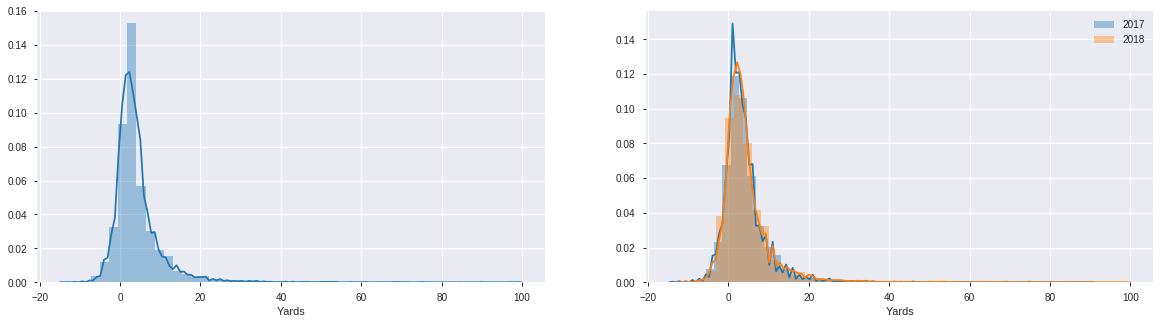

In [14]:
# yards
print(train_df["Yards"].median())
print(train_2017["Yards"].median())
print(train_2018["Yards"].median())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(train_df["Yards"])
plt.subplot(1,2,2)
sns.distplot(train_2017["Yards"], label="2017")
sns.distplot(train_2018["Yards"], label="2018")
plt.legend()

In [15]:
train_df[train_df.Yards==0].shape[0] / train_df.shape[0]

0.09257261231712054

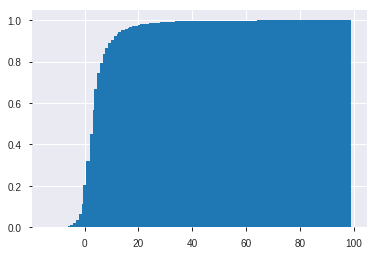

In [16]:
train = train_df.drop_duplicates(subset="PlayId") 
dist = train["Yards"].hist(density = True, cumulative = True, bins = 200)

In [17]:
train_own = train[train["FieldPosition"] == train["PossessionTeam"]]
train_other = train[train["FieldPosition"] != train["PossessionTeam"]]

own_cdf = np.histogram(train_own["Yards"], bins=199, range=(-99,100), density=True)[0].cumsum()
other_cdf = np.histogram(train_other["Yards"], bins=199, range=(-99,100), density=True)[0].cumsum()

Despite the fact that the cumulative distributions of yards seem similar, when we check the values in detail, the values are clearly different. When the value of field position and possessionteam is different, there's no chance that team progress the last 50 yards.

Text(0.5, 1.0, 'Other cdf')

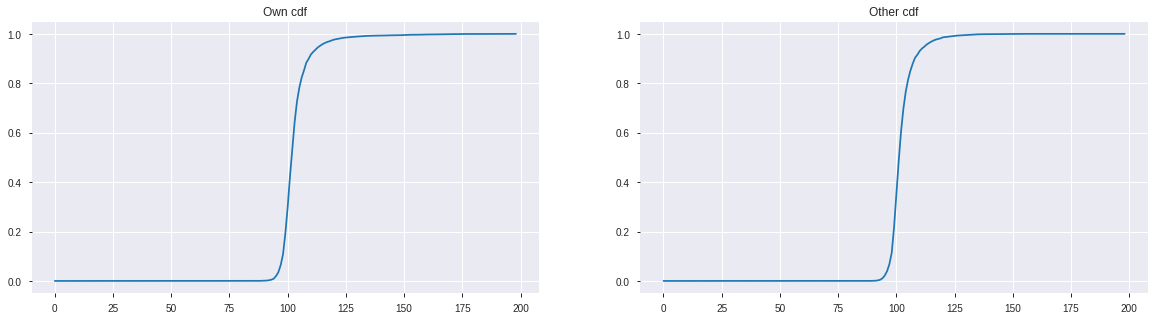

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(own_cdf)
plt.title("Own cdf")
plt.subplot(1,2,2)
plt.plot(other_cdf)
plt.title("Other cdf")

In [19]:
# own_cdf
# other_cdf

NameError: name 'tmp_2017' is not defined

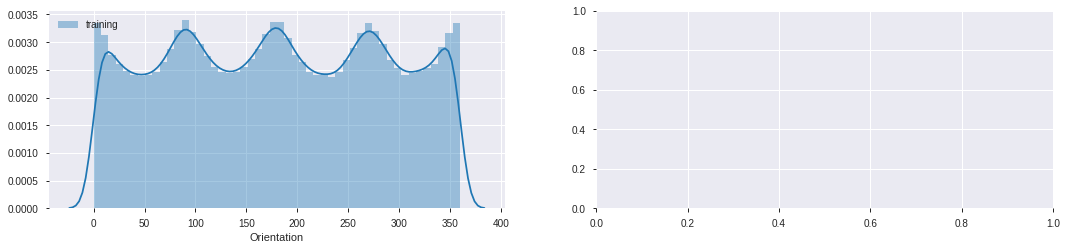

In [20]:
plt.figure(figsize=(18,8))
tmp_df = train_df["Orientation"].dropna()
#tmp_2017 = train_2017["Orientation"].apply(lambda x: 360+x-90 if x<=90 else x - 90).dropna() 
#tmp_2017 = train_2017["Orientation"].apply(lambda x: x+ 90 - 360 if x>270 else x + 90).dropna() 
#tmp_2017 = train_2017["Orientation"].dropna()
tmp_2018 = train_2018["Orientation"].dropna()
tmp_test = test_df["Orientation"].dropna()
plt.subplot(2, 2, 1)
sns.distplot(tmp_df, label="training")
plt.legend()
plt.subplot(2, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

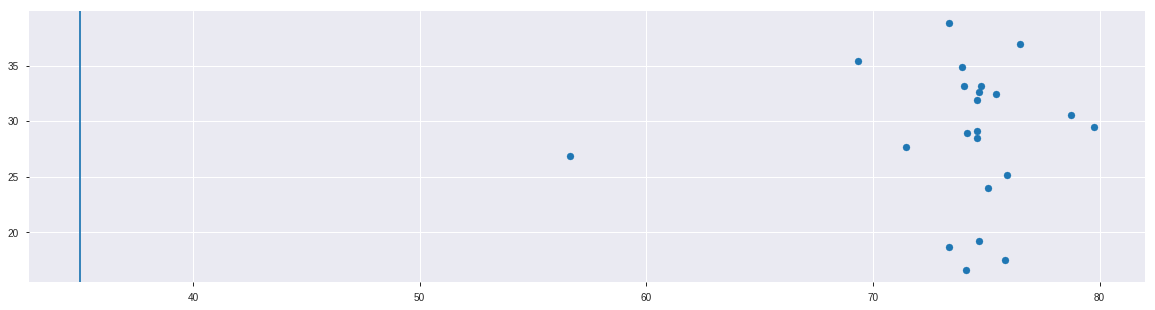

In [21]:
plt.figure(figsize=(20,5))
plt.scatter(train_df.iloc[0:22]["X"], train_df.iloc[0:22]["Y"])
plt.axvline(train_df.iloc[1]["YardLine"])

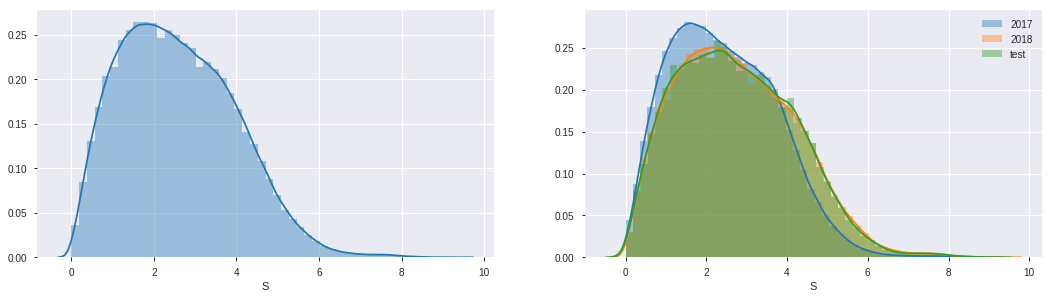

In [22]:
# S: player spped: faster in 2018 than in 2017
plt.figure(figsize=(18,10))
plt.subplot(2, 2, 1)
sns.distplot(train_df["S"])
plt.subplot(2, 2, 2)
sns.distplot(train_2017["S"], label = "2017")
sns.distplot(train_2018["S"], label = "2018")
sns.distplot(test_df["S"], label = "test")
plt.legend()

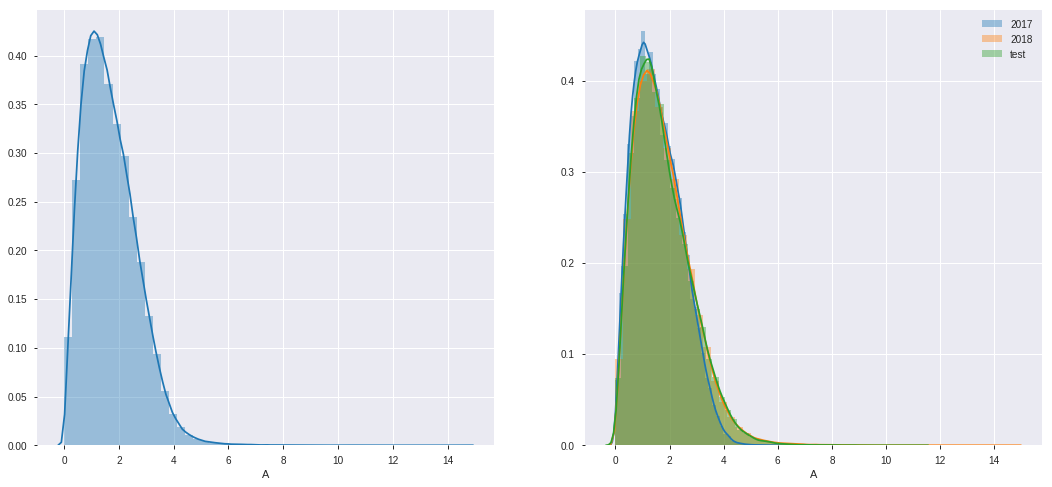

In [23]:
# A: acceleration, higher in 2018 than in 2017
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
sns.distplot(train_df["A"])
plt.subplot(1, 2, 2)
sns.distplot(train_2017["A"], label = "2017")
sns.distplot(train_2018["A"], label = "2018")
sns.distplot(test_df["A"], label = "test")
plt.legend()

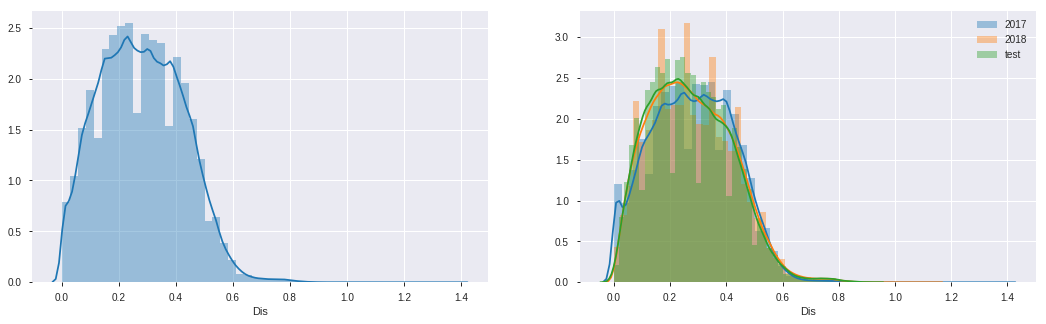

In [24]:
# Dis: distance moved from the previous point
plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
sns.distplot(train_df["Dis"])
plt.subplot(1, 2, 2)
sns.distplot(train_2017["Dis"], label = "2017")
sns.distplot(train_2018["Dis"], label = "2018")
sns.distplot(test_df["Dis"], label = "test")
plt.legend()

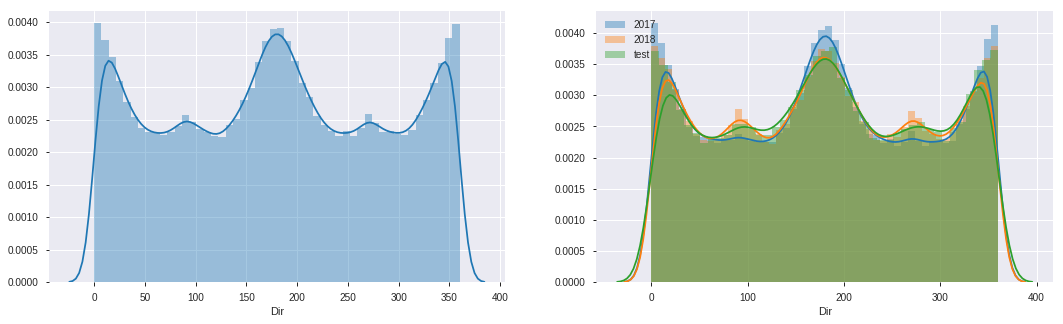

In [25]:
# Dir: angle of player motion
plt.figure(figsize=(18,5))
tmp_df = train_df["Dir"].dropna()
tmp_2017 = train_2017["Dir"].dropna()
tmp_2018 = train_2018["Dir"].dropna()
tmp_test = test_df["Dir"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.legend()
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

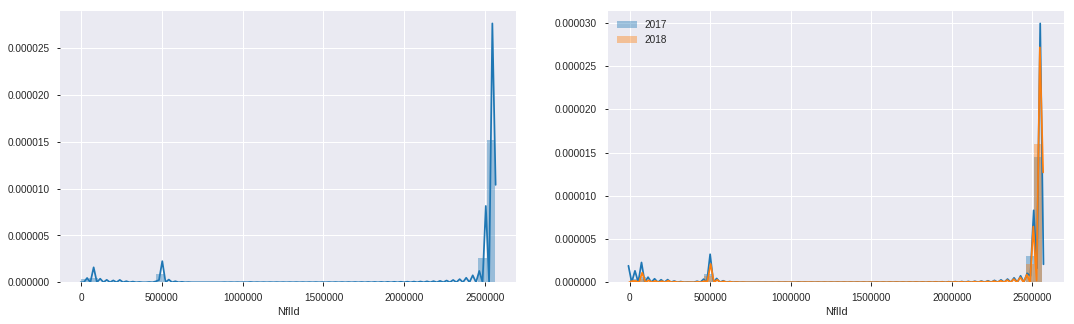

In [26]:
plt.figure(figsize=(18,5))
tmp_df = train_df["NflId"].dropna()
tmp_2017 = train_2017["NflId"].dropna()
tmp_2018 = train_2018["NflId"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

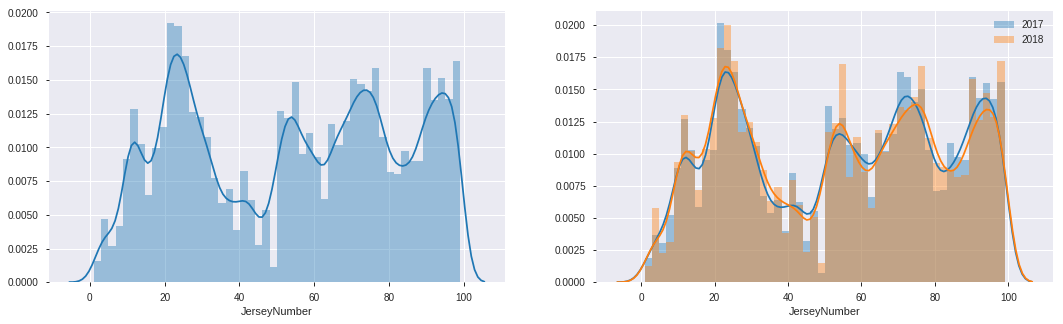

In [27]:
plt.figure(figsize=(18,5))
tmp_df = train_df["JerseyNumber"].dropna()
tmp_2017 = train_2017["JerseyNumber"].dropna()
tmp_2018 = train_2018["JerseyNumber"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

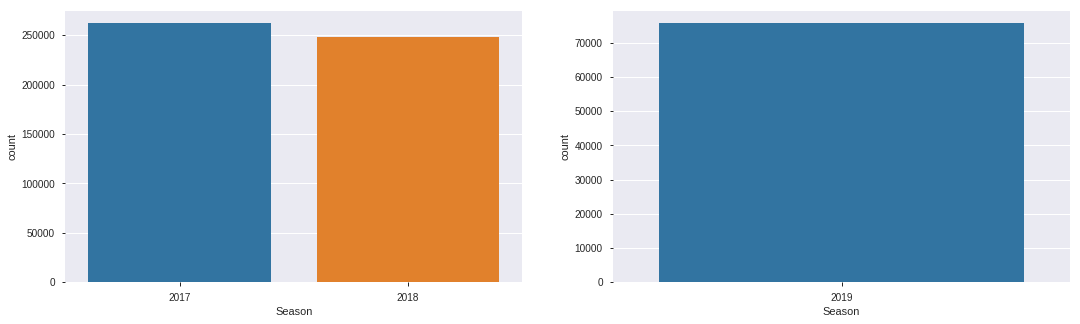

In [28]:
plt.figure(figsize=(18,5))
tmp_df = train_df["Season"].dropna()
tmp_test = test_df["Season"].dropna()
plt.subplot(1, 2, 1)
sns.countplot(tmp_df)
plt.subplot(1, 2, 2)
sns.countplot(tmp_test)

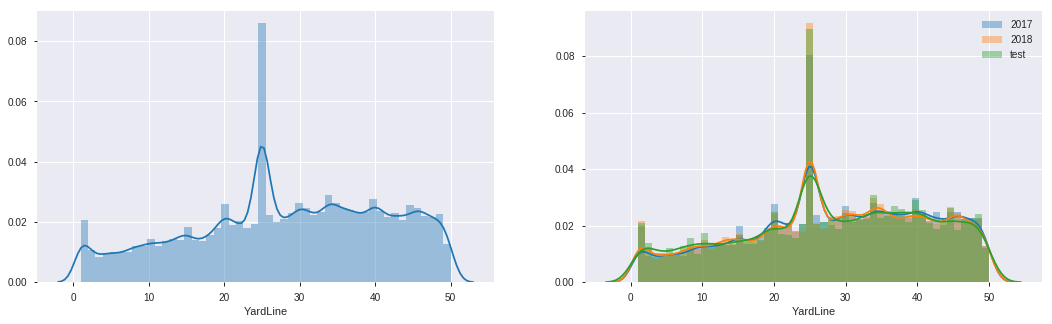

In [29]:
# yardline： scrimmage line (line between offense and defense. ball is set on the line and attack starts when the ball moves
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[14]].dropna()
tmp_2017 = train_2017[train_2017.columns[14]].dropna()
tmp_2018 = train_2018[train_2018.columns[14]].dropna()
tmp_test = test_df[test_df.columns[14]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

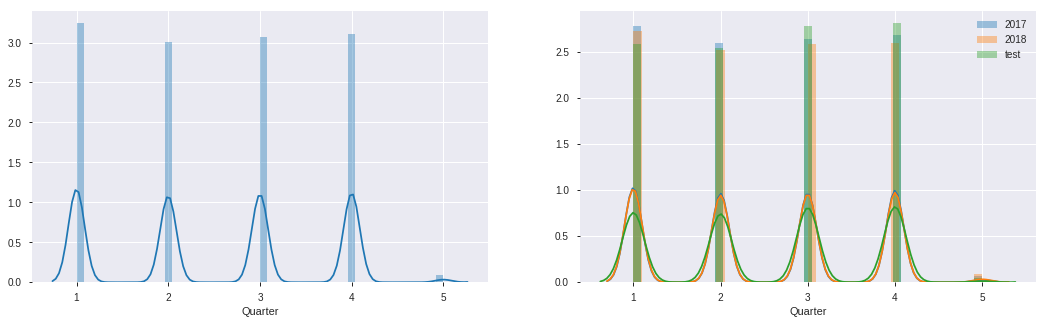

In [30]:
plt.figure(figsize=(18,5))
tmp_df = train_df["Quarter"].dropna()
tmp_2017 = train_2017["Quarter"].dropna()
tmp_2018 = train_2018["Quarter"].dropna()
tmp_test = test_df["Quarter"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

In [31]:
train_df["PossessionTeam"].value_counts()          

NE     18700
LA     17952
BLT    17864
NO     17490
JAX    17490
SEA    17094
DAL    16918
HST    16764
MIN    16742
LAC    16698
DEN    16654
TEN    16544
PHI    16478
CHI    16368
BUF    16214
SF     16192
IND    16060
NYG    15642
DET    15554
NYJ    15532
ATL    15488
OAK    15422
PIT    15312
ARZ    15092
WAS    15092
KC     14300
CIN    14278
TB     14212
MIA    14168
CAR    14146
CLV    14102
GB     13200
Name: PossessionTeam, dtype: int64

In [32]:
train_df["Down"].value_counts()

1    292666
2    172986
3     39908
4      4202
Name: Down, dtype: int64

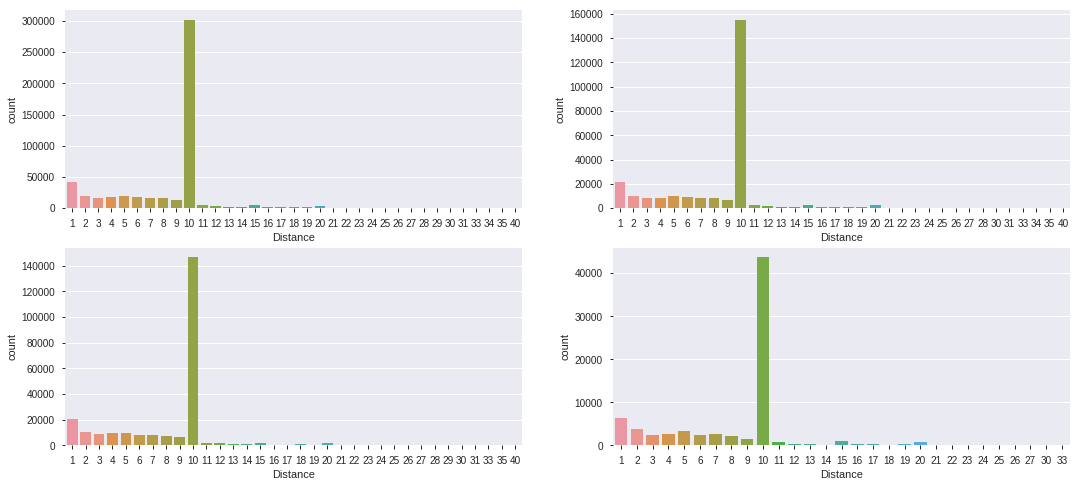

In [33]:
# Distance: the distance necessary for first down (10 yards in 4 attacks)
plt.figure(figsize=(18,8))
plt.subplot(2, 2, 1)
sns.countplot(train_df["Distance"])
plt.subplot(2, 2, 2)
sns.countplot(train_2017["Distance"])
plt.legend()
plt.subplot(2, 2, 3)
sns.countplot(train_2018["Distance"])
plt.legend()
plt.subplot(2, 2, 4)
sns.countplot(test_df["Distance"])

In [34]:
print(train_df["FieldPosition"].value_counts())

BUF    17468
OAK    17182
NYG    17160
ARZ    17072
MIA    16984
NYJ    16896
CLV    16676
CIN    16588
DEN    16566
SF     16456
SEA    16412
HST    16346
CHI    16060
IND    16038
TEN    15972
GB     15862
LA     15818
JAX    15620
DAL    15576
WAS    15554
DET    15444
BLT    15356
TB     15246
MIN    15158
LAC    15114
ATL    14938
KC     14784
NE     14718
PIT    14366
PHI    13442
NO     13332
CAR    13134
Name: FieldPosition, dtype: int64


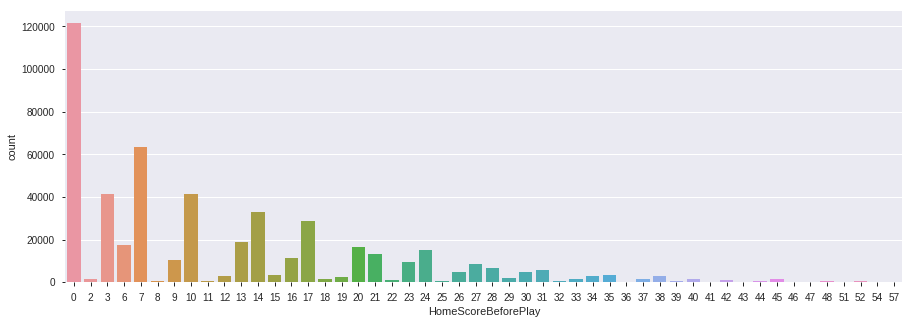

In [35]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["HomeScoreBeforePlay"])

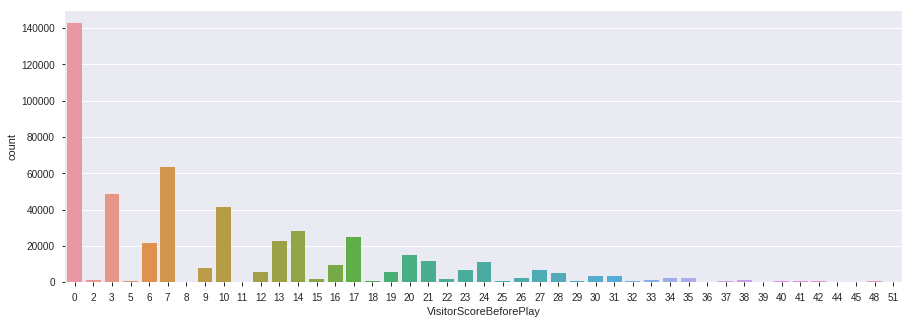

In [36]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["VisitorScoreBeforePlay"])

In [37]:
# NflIdrusher: 
print(train_df[train_df.columns[23]].value_counts())

2555224    11814
2552475    11726
2555418    11396
2552469    10010
2557917     9900
           ...  
2543477       22
2561358       22
2557863       22
2543475       22
2506931       22
Name: NflIdRusher, Length: 371, dtype: int64


In [38]:
print(train_df["OffenseFormation"].value_counts())
print(train_2017["OffenseFormation"].value_counts())
print(train_2018["OffenseFormation"].value_counts())
print(test_df["OffenseFormation"].value_counts())

SINGLEBACK    225434
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
ACE               22
Name: OffenseFormation, dtype: int64
SINGLEBACK    117194
SHOTGUN        71192
I_FORM         60786
JUMBO           6094
PISTOL          5940
WILDCAT          330
EMPTY            176
ACE               22
Name: OffenseFormation, dtype: int64
SINGLEBACK    108240
SHOTGUN        79772
I_FORM         45276
PISTOL          7480
JUMBO           5368
WILDCAT         1452
EMPTY            330
Name: OffenseFormation, dtype: int64
SINGLEBACK    32142
SHOTGUN       25146
I_FORM        13112
PISTOL         3498
JUMBO          1386
WILDCAT         286
EMPTY            66
Name: OffenseFormation, dtype: int64


In [39]:
# OffensePersonel: position group in offense team (RB, TE, WR, OL, DL, QB)
print(train_df["OffensePersonnel"].value_counts())

1 RB, 1 TE, 3 WR               232958
1 RB, 2 TE, 2 WR               114092
2 RB, 1 TE, 2 WR                53636
1 RB, 3 TE, 1 WR                31306
2 RB, 2 TE, 1 WR                25828
6 OL, 1 RB, 2 TE, 1 WR           9680
6 OL, 1 RB, 1 TE, 2 WR           8426
6 OL, 2 RB, 1 TE, 1 WR           5896
6 OL, 2 RB, 2 TE, 0 WR           3762
2 RB, 0 TE, 3 WR                 3454
1 RB, 2 TE, 1 WR,1 DL            3102
6 OL, 1 RB, 0 TE, 3 WR           2178
1 RB, 0 TE, 4 WR                 1870
0 RB, 1 TE, 4 WR                 1672
2 QB, 1 RB, 1 TE, 2 WR           1562
2 RB, 3 TE, 0 WR                 1408
6 OL, 1 RB, 3 TE, 0 WR           1210
6 OL, 2 RB, 0 TE, 2 WR           1056
1 RB, 1 TE, 2 WR,1 DL             748
7 OL, 1 RB, 0 TE, 2 WR            682
3 RB, 1 TE, 1 WR                  572
2 QB, 2 RB, 1 TE, 1 WR            550
1 RB, 3 TE, 0 WR,1 DL             440
6 OL, 1 RB, 2 TE, 0 WR,1 DL       352
3 RB, 0 TE, 2 WR                  286
2 QB, 1 RB, 2 TE, 1 WR            264
6 OL, 1 RB, 

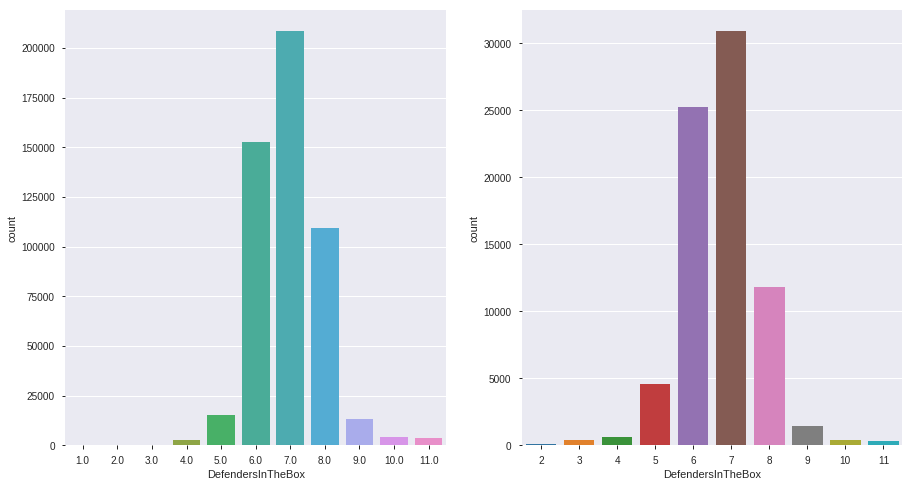

In [40]:
# defenders in the box: no of defenders in scrimmage line
tmp_df = train_df["DefendersInTheBox"].dropna()
tmp_test = test_df["DefendersInTheBox"].dropna()
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.countplot(tmp_df)
plt.subplot(1,2,2)
sns.countplot(tmp_test)

In [41]:
# defence personnel: group of defense position
print(train_df["DefensePersonnel"].value_counts())
print(test_df["DefensePersonnel"].value_counts())

4 DL, 2 LB, 5 DB          139876
4 DL, 3 LB, 4 DB          136510
3 DL, 4 LB, 4 DB           80432
2 DL, 4 LB, 5 DB           56936
3 DL, 3 LB, 5 DB           48884
2 DL, 3 LB, 6 DB           11638
4 DL, 1 LB, 6 DB            9196
4 DL, 4 LB, 3 DB            5214
3 DL, 2 LB, 6 DB            4246
5 DL, 2 LB, 4 DB            3542
5 DL, 3 LB, 3 DB            2376
1 DL, 4 LB, 6 DB            1430
3 DL, 5 LB, 3 DB            1408
6 DL, 4 LB, 1 DB            1232
5 DL, 4 LB, 2 DB            1166
6 DL, 3 LB, 2 DB            1034
5 DL, 1 LB, 5 DB             902
6 DL, 2 LB, 3 DB             704
1 DL, 5 LB, 5 DB             682
2 DL, 5 LB, 4 DB             484
2 DL, 2 LB, 7 DB             286
1 DL, 3 LB, 7 DB             286
3 DL, 1 LB, 7 DB             264
5 DL, 3 LB, 2 DB, 1 OL       154
5 DL, 5 LB, 1 DB             154
0 DL, 5 LB, 6 DB             132
4 DL, 5 LB, 2 DB             110
0 DL, 4 LB, 7 DB              88
2 DL, 4 LB, 4 DB, 1 OL        66
5 DL, 4 LB, 1 DB, 1 OL        66
4 DL, 0 LB

In [42]:
print(train_df["PlayDirection"].value_counts())
print(train_2017["PlayDirection"].value_counts())
print(train_2018["PlayDirection"].value_counts())
print(test_df["PlayDirection"].value_counts())

left     256454
right    253308
Name: PlayDirection, dtype: int64
right    131472
left     130328
Name: PlayDirection, dtype: int64
left     126126
right    121836
Name: PlayDirection, dtype: int64
left     38192
right    37444
Name: PlayDirection, dtype: int64


In [43]:
# time hand off: means giving ball from QB to RB by hand in run play, tend to increase in rain)
print(train_df["TimeHandoff"].value_counts())
# time snap:（snap means that passing ball from center by following voice of QB in attack snap→handoff
print(train_df["TimeSnap"].value_counts())

2018-10-07T17:17:43.000Z    66
2017-12-31T23:51:34.000Z    44
2017-12-31T20:11:41.000Z    44
2017-11-12T20:03:34.000Z    44
2017-09-10T17:06:45.000Z    44
                            ..
2018-09-09T18:39:13.000Z    22
2018-09-16T19:14:16.000Z    22
2017-09-17T22:45:02.000Z    22
2017-12-12T01:32:16.000Z    22
2017-10-01T18:43:19.000Z    22
Name: TimeHandoff, Length: 22935, dtype: int64
2018-10-07T17:17:41.000Z    66
2017-12-31T21:55:29.000Z    66
2017-12-17T20:20:38.000Z    44
2018-12-16T18:04:37.000Z    44
2018-10-28T18:04:35.000Z    44
                            ..
2018-12-30T20:41:28.000Z    22
2018-10-28T19:07:01.000Z    22
2018-12-16T22:02:25.000Z    22
2017-10-24T02:25:59.000Z    22
2018-09-14T01:24:02.000Z    22
Name: TimeSnap, Length: 22943, dtype: int64


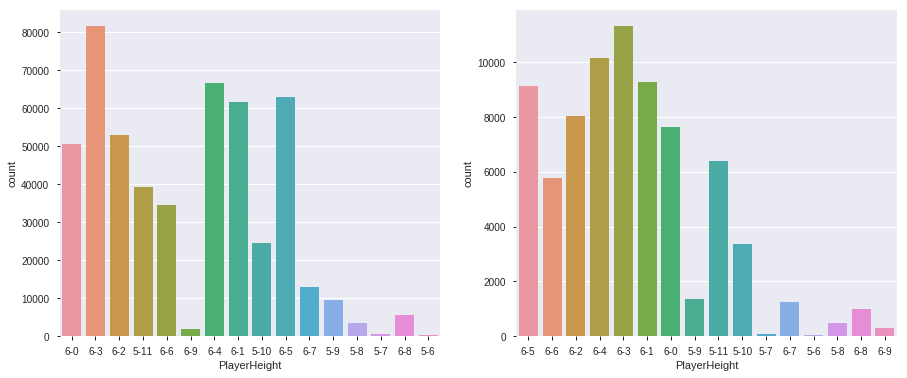

In [44]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(train_df["PlayerHeight"])
plt.subplot(1,2,2)
sns.countplot(test_df["PlayerHeight"])

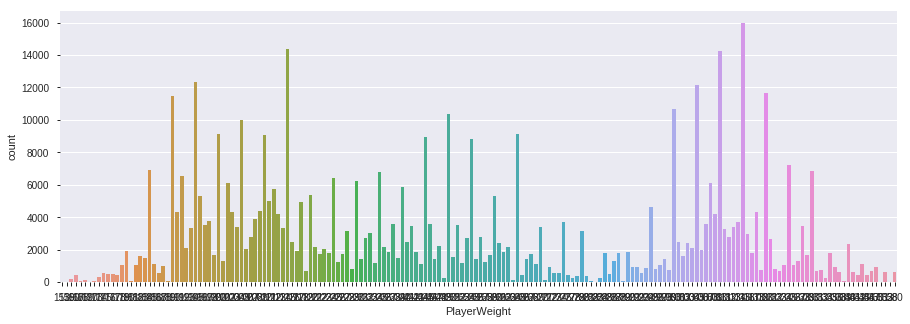

In [45]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["PlayerWeight"])

In [46]:
print(train_df["PlayerCollegeName"].value_counts())

Alabama            16174
Ohio State         13984
Louisiana State    12211
Florida            11775
Georgia            11686
                   ...  
Texas Southern         3
Cal Poly               3
Stetson                2
Eastern Oregon         2
Alcorn State           1
Name: PlayerCollegeName, Length: 301, dtype: int64


In [47]:
print(train_df["Position"].value_counts())

CB     56686
WR     53325
G      42114
T      42046
DE     35890
DT     35637
OLB    34110
TE     33237
FS     24607
C      24062
RB     23908
QB     23290
SS     20540
ILB    18541
MLB    10208
NT      8226
LB      6699
OT      6097
FB      3211
OG      3073
DB      1931
S       1641
HB       647
SAF       19
DL        17
Name: Position, dtype: int64


In [48]:
print(train_df["HomeTeamAbbr"].value_counts())
print("team no: ", len(train_df["HomeTeamAbbr"].unique()))

SF     17402
NYG    17336
NE     17248
BUF    17204
BAL    17094
SEA    16962
CIN    16588
IND    16544
DEN    16478
OAK    16456
ARI    16434
NYJ    16236
MIN    16170
JAX    15972
DAL    15950
CLE    15928
HOU    15884
TEN    15862
LA     15642
NO     15554
LAC    15532
MIA    15400
WAS    15356
KC     15334
CHI    15334
GB     15312
DET    15246
ATL    15246
PIT    14850
TB     14696
PHI    14476
CAR    14036
Name: HomeTeamAbbr, dtype: int64
team no:  32


In [49]:
print(train_df["VisitorTeamAbbr"].value_counts())
print("team no: ", len(train_df["VisitorTeamAbbr"].unique()))

LA     17864
JAX    17072
IND    16764
LAC    16720
DEN    16698
TEN    16478
OAK    16478
WAS    16390
NYJ    16390
DET    16368
ARI    16302
SF     16302
MIA    16236
HOU    16170
NO     16038
CHI    16038
KC     15862
DAL    15840
BAL    15818
MIN    15774
SEA    15774
CIN    15708
BUF    15664
NE     15510
CLE    15422
TB     15378
NYG    15356
GB     15312
PIT    15114
ATL    15092
PHI    14168
CAR    13662
Name: VisitorTeamAbbr, dtype: int64
team no:  32


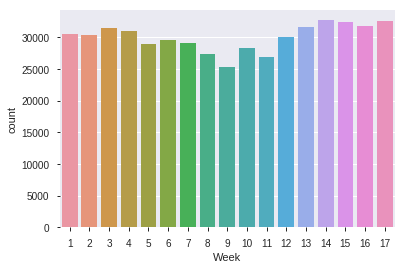

In [50]:
sns.countplot(train_df["Week"])

In [51]:
print(train_df["Stadium"].value_counts())
# third-team stadium: 
#Sports Authority Field at Mile HighとBroncos Stadium at Mile Highは同じ意味なので修正する
# State Farm StadiumとUniversity of Phoenix Stadiumは同じ意味なので修正する

# "Empower Field at Mile High" if x == "Sports Authority Field at Mile High" or x == "Broncos Stadium at Mile High" 
# "State Farm Stadium" if x == "University of Phoenix Stadium"

#third_party_stadium = ["Wembley Stadium", "Twickenham Stadium", "Estadio Azteca", "Tottenham Hotspur Stadium"]

MetLife Stadium                        21054
Levis Stadium                          17402
Gillette Stadium                       17248
New Era Field                          17204
Lucas Oil Stadium                      16544
U.S. Bank Stadium                      16170
AT&T Stadium                           15950
Nissan Stadium                         15862
Mercedes-Benz Superdome                15554
Paul Brown Stadium                     15444
FedExField                             15356
Soldier Field                          15334
Arrowhead Stadium                      15334
Ford Field                             15246
Heinz Field                            14850
Raymond James Stadium                  14696
StubHub Center                         14630
CenturyLink Field                      14586
Hard Rock Stadium                      14564
Lincoln Financial Field                14476
Mercedes-Benz Stadium                  14388
Lambeau Field                          14300
Bank of Am

In [52]:
print("only 2018:", set(train_2018[train_2018.columns[40]].unique()) - set(train_2017[train_2017.columns[40]].unique()))
print("only 2017:", set(train_2017[train_2017.columns[40]].unique()) - set(train_2018[train_2018.columns[40]].unique()))

only 2018: {'TIAA Bank Field', 'Los Angeles Memorial Coliesum', 'Broncos Stadium At Mile High', 'Metlife Stadium', 'CenturyField', 'FirstEnergyStadium', 'State Farm Stadium', 'Broncos Stadium at Mile High', 'Lambeau field', 'Paul Brown Stdium'}
only 2017: {'University of Phoenix Stadium', 'Sports Authority Field at Mile High', 'M & T Bank Stadium', 'Estadio Azteca', 'Mercedes-Benz Dome', 'First Energy Stadium', 'Twickenham', 'EverBank Field', 'Twickenham Stadium', 'Everbank Field', 'CenturyLink', 'Oakland Alameda-County Coliseum'}


In [53]:
print(train_df["Location"].value_counts())

East Rutherford, NJ          30096
Santa Clara, CA              17402
Indianapolis, Ind.           16544
Denver, CO                   16478
Glendale, AZ                 16434
Minneapolis, MN              16170
Baltimore, Md.               16016
Nashville, TN                15862
Orchard Park NY              15488
Landover, MD                 15356
Green Bay, WI                15312
Atlanta, GA                  15246
Arlington, Texas             15246
Foxborough, MA               15224
Tampa, FL                    14696
Seattle, WA                  14630
Carson, CA                   14630
Oakland, CA                  14564
Chicago, IL                  14498
Cincinnati, Ohio             14476
Kansas City, MO              14190
Los Angeles, Calif.          13706
Miami Gardens, Fla.          13486
Pittsburgh                   13178
Philadelphia, Pa.            13156
Jacksonville, FL             11352
New Orleans, LA              11110
Detroit                      10670
Houston, TX         

In [54]:
print(train_df["StadiumType"].value_counts())

Outdoor                   267696
Outdoors                   67474
Indoors                    40854
Dome                       17336
Indoor                     16148
Retractable Roof           15884
Open                        9614
Retr. Roof-Closed           7172
Retr. Roof - Closed         6446
Domed, closed               5918
Domed, open                 2684
Closed Dome                 2134
Domed                       1826
Dome, closed                1826
Oudoor                      1188
Retr. Roof Closed           1056
Indoor, Roof Closed         1056
Retr. Roof-Open              990
Outddors                     968
Bowl                         968
Heinz Field                  902
Retr. Roof - Open            880
Outdoor Retr Roof-Open       880
Outdor                       858
Ourdoor                      858
Indoor, Open Roof            858
Outside                      814
Cloudy                       770
Domed, Open                  770
Name: StadiumType, dtype: int64


In [55]:
# print(train_df["Turf"].value_counts())
grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
train_df['Turf'] = np.where(train_df.Turf.str.lower().isin(grass_labels), "Natural", "Artificial")

In [56]:
#print(train_df["GameWeather"].unique())
train_df.GameWeather.value_counts(normalize=True, dropna=False).cumsum().head(15)

Cloudy                0.224548
Sunny                 0.430581
Partly Cloudy         0.520953
Clear                 0.607786
NaN                   0.693410
Rain                  0.730482
Mostly Cloudy         0.766216
Controlled Climate    0.790816
N/A (Indoors)         0.812136
Indoor                0.824263
Mostly Sunny          0.835872
Indoors               0.847007
Partly Sunny          0.857537
Fair                  0.867291
N/A Indoor            0.875577
Name: GameWeather, dtype: float64

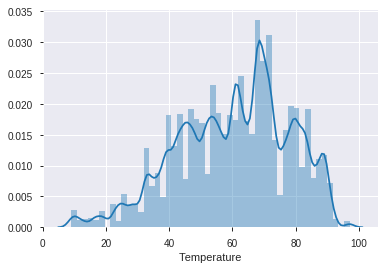

In [57]:
sns.distplot(train_df["Temperature"].dropna())

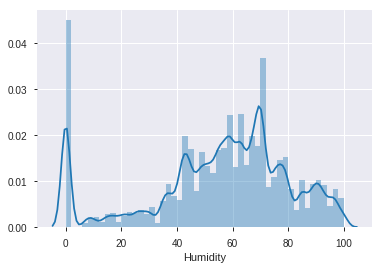

In [58]:
sns.distplot(train_df["Humidity"].dropna())

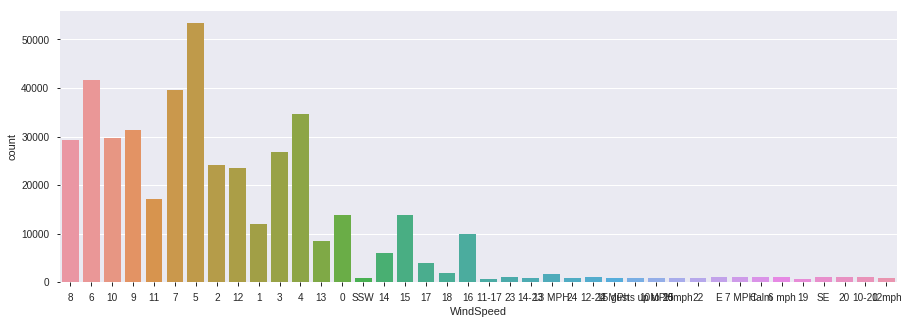

In [59]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["WindSpeed"].dropna())

In [60]:
#train_df["WindDirection"].value_counts()
train_df.WindDirection.value_counts(normalize=True, dropna=False).cumsum().head(30)

NaN          0.157395
NE           0.216736
NW           0.270165
SW           0.320832
SE           0.371413
WSW          0.418929
N            0.464417
W            0.507963
S            0.549912
NNE          0.589918
South        0.629796
SSW          0.668853
WNW          0.706357
North        0.740063
NNW          0.767597
West         0.794312
SSE          0.820552
E            0.845712
ENE          0.866903
ESE          0.886280
East         0.900695
Northwest    0.908679
From SW      0.916275
Northeast    0.923439
NorthEast    0.929740
From S       0.935911
s            0.941263
SouthWest    0.945449
Southeast    0.949247
Southwest    0.952786
Name: WindDirection, dtype: float64

# feature engineering

In [61]:
# Data cleaning ---
# Before EDA, preprocessing is necessary because there's inconsistency in the data.
#def strtoseconds(txt):
#    txt = txt.split(':')
#    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
#    return ans

#def str_to_float(txt):
#    try:
#        return float(txt)
#    except:
#        return -1

# data cleaning 
#map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
#for abb in train_df['PossessionTeam'].unique():
#    map_abbr[abb] = abb
#train_df['PossessionTeam'] = train_df['PossessionTeam'].map(map_abbr)
#train_df['HomeTeamAbbr'] = train_df['HomeTeamAbbr'].map(map_abbr)
#train_df['VisitorTeamAbbr'] = train_df['VisitorTeamAbbr'].map(map_abbr)

# offense formation
train_df["OffenseFormation"] = train_df["OffenseFormation"].fillna("Unknown") 

# Stadium
train_df["Stadium"] = train_df["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))

# Location
#train_df["Location"] = train_df["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
#                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
#                        else ("Charlotte, NC" if x == "Charlotte, North Carolina"
#                        else ("Chicago, IL" if x == "Chicago. IL"
#                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
#                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
#                        else ("Detroit, MI" if x == "Detroit"
#                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
#                        else ("Foxborough, MA" if x == "Foxborough, Ma"
#                        else ("Houston, TX" if x == "Houston, Texas"
#                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
#                        else ("London" if x == "London, England"
#                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
#                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
#                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
#                        else ("Orchard Park, NY" if x == "Orchard Park NY"
#                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
#                        else ("Pittsburgh, PA" if x == "Pittsburgh"
#                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))

# Turf
#train_df["Turf"] = train_df["Turf"].map(lambda x: "Artificial" if x == "Artifical"
#                                       else ("Field Turf" if x == "FieldTurf" or x == "Field turf"
#                                       else ("FieldTurf 360" if x == "FieldTurf360"
#                                       else ("Natural Grass" if x == "natural grass" or x == "Naturall Grass" or x == "Natural grass" or x == "Natural"
#                                       else ("Grass" if x == "grass"
#                                       else ("UBU Speed Series-S5-M" if x == "UBU Sports Speed S5-M" else x))))))

# Player Height
#train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

# stadium type
#outdoor =['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
#         'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']
#indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed',
#                   'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']
#indoor_open = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
#dome_closed = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
#dome_open = ['Domed, Open', 'Domed, open']

#train_df['StadiumType'] = train_df['StadiumType'].apply(lambda x: "outdoor" if x in outdoor 
#                                                         else ("indoor closed" if x in indoor_closed
#                                                        else ("indoor open" if x in indoor_open
#                                                        else ("dome_closed" if x in dome_closed
#                                                        else ("dome_open" if x in dome_open else "unknown")))))

# Game weather
#rain = ['Rainy', 'Rain Chance 40%', 'Showers',
#          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
#          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']
#overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
#              'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
#              'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
#              'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
#              'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
#              'Partly Cloudy', 'Cloudy']
#clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
#           'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
#           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
#           'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
#           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
#           'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']
#snow = ['Heavy lake effect snow', 'Snow']
#none = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']

#train_df['GameWeather'] = train_df['GameWeather'].apply(lambda x: "rain" if x in rain 
#                                                         else ("overcast" if x in overcast
#                                                        else ("clear" if x in clear
#                                                        else ("snow" if x in snow
#                                                        else ("indoor" if x in none else "unknown")))))

# wind speed
#train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
#train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
#train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
#train_df['WindSpeed'] = train_df['WindSpeed'].apply(str_to_float)

# wind direction
#train_df['WindDirection'] = train_df['WindDirection'].apply(lambda x: "north" if x == "N" or x == "FROM S"
#                                                   else ("south" if x == 'S' or x== 'FROM N'
#                                                   else ("west" if x == 'W' or x == 'FROM E'
#                                                   else ("east" if x == 'E' or x == 'FROM W'
#                                                   else ("north east" if x == 'FROM SW' or x == 'FROM SSW' or x == 'FROM WSW'
#                                                   else ("north west" if x == 'FROM SE' or x == 'FROM SSE' or x == 'FROM ESE'
#                                                   else ("south east" if x == 'FROM NW' or x == 'FROM NNW' or x == 'FROM WNW'
#                                                   else ("south west" if x == 'FROM NE' or x == 'FROM NNE' or x == 'FROM ENE'
#                                                   else ("north west" if x == 'NW' or x == 'NORTHWEST'
#                                                   else ("north east" if x == 'NE' or x == 'NORTH EAST'
#                                                   else ("south west" if x == 'SW' or x == 'SOUTHWEST'
#                                                   else ("south east" if x == 'SE' or x == 'SOUTHEAST' else "unknown"))))))))))))

# league grouping
#afc_east = ["NE", "BUF", "NYJ", "MIA"]
#afc_north = ["BLT", "CLV", "PIT", "CIN"]
#afc_south = ["JAX", "HST", "TEN", "IND"]
#afc_west = ["LAC", "DEN", "OAK", "KC"]

#nfc_east = ["DAL", "PHI", "NYG", "WAS"]
#nfc_north = ["MIN", "CHI", "DET", "GB"]
#nfc_south = ["NO", "ATL", "TB", "CAR"]
#nfc_west = ["SEA","LA", "SF", "ARZ"]     

# train_df['HomeTeamLeague'] = train_df['HomeTeamAbbr'].apply(lambda x: "AFC" if x in afc_east or x in afc_north or x in afc_south or x in afc_west else "NFC")
# train_df['VisitorTeamLeague'] = train_df['VisitorTeamAbbr'].apply(lambda x: "AFC" if x in afc_east or x in afc_north or x in afc_south or x in afc_west else "NFC")
#train_df['HomeTeamDivision'] = train_df['HomeTeamAbbr'].apply(lambda x: "AFC_east" if x in afc_east 
#                                                              else ("AFC_north" if x in afc_north 
#                                                              else ("AFC_south" if x in afc_south 
#                                                              else ("AFC_west" if x in afc_west
#                                                              else ("NFC_east" if x in nfc_east
#                                                              else ("NFC_north" if x in nfc_north 
#                                                              else ("NFC_south" if x in nfc_south 
#                                                              else "NFC_west"    )))))))
#train_df['VisitorTeamDivision'] = train_df['VisitorTeamAbbr'].apply(lambda x: "AFC_east" if x in afc_east 
#                                                              else ("AFC_north" if x in afc_north 
#                                                              else ("AFC_south" if x in afc_south 
#                                                              else ("AFC_west" if x in afc_west
#                                                              else ("NFC_east" if x in nfc_east
#                                                              else ("NFC_north" if x in nfc_north 
#                                                              else ("NFC_south" if x in nfc_south 
#                                                              else "NFC_west"    )))))))

#train_df["Margin"] = (train_df["HomeScoreBeforePlay"] - 
#                     train_df["VisitorScoreBeforePlay"]) + 2 * (1 - (train_df["PossessionTeam"] == 
#                                                                      train_df["HomeTeamAbbr"]).astype(int)) * (train_df["VisitorScoreBeforePlay"] 
#                                                                                                                - train_df["HomeScoreBeforePlay"])

In [62]:
# create new features
train_df['IsRusher'] = train_df['NflId'] == train_df['NflIdRusher'] 
def func(row):
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return "home"
    else:
        return "away"
train_df["OnOffense"] = train_df[["PossessionTeam", "HomeTeamAbbr"]].apply(func, axis=1)
train_df["OnOffense"] = train_df["OnOffense"] == train_df["Team"]
train_df['ToLeft'] = train_df.PlayDirection == "left" # to unite attack direction

In [63]:
# which day is the game played 
#train_df["Day"] = train_df['GameId'].apply(str)
#train_df["Day"] = train_df["Day"].apply(lambda x: x[:8]) 
#train_df["Day"] = pd.to_datetime(train_df["Day"])
#train_df["Day"] = train_df["Day"].apply(lambda x: x.weekday_name)
#train_df["Day"].value_counts()

# which team wins (apply after data compression)
win_count = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
lose_count = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
train_df2017 = train_df[train_df["Season"] == 2017]
game_id2017 = list(train_df2017["GameId"].unique())

hometeam_wins_2017 = np.zeros(train_df2017.shape[0])
hometeam_loses_2017 = np.zeros(train_df2017.shape[0])
visitorteam_wins_2017 = np.zeros(train_df2017.shape[0])
visitorteam_loses_2017 = np.zeros(train_df2017.shape[0])

count_index = 0
for i in game_id2017:
    #print(train_df[train_df["GameId"]==i].tail(1)[["HomeTeamAbbr", "VisitorTeamAbbr", "HomeScoreBeforePlay", "VisitorScoreBeforePlay"]])
    game_length = train_df2017[train_df2017["GameId"]==i].shape[0]
    tmp_df = train_df2017[train_df2017["GameId"]==i].tail(1)
    
    # check team performance before tha game
    hometeam_wins_2017[count_index: count_index+game_length] = win_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    hometeam_loses_2017[count_index: count_index+game_length] = lose_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    visitorteam_wins_2017[count_index: count_index+game_length] = win_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    visitorteam_loses_2017[count_index: count_index+game_length] = lose_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    
    # calculate win or lose in this game
    if tmp_df["HomeScoreBeforePlay"].values[0] > tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count[tmp_df["HomeTeamAbbr"].values[0]- 1] += 1
        lose_count[tmp_df["VisitorTeamAbbr"].values[0]- 1] += 1
    elif tmp_df["HomeScoreBeforePlay"].values[0] < tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count[tmp_df["VisitorTeamAbbr"].values[0] - 1] += 1
        lose_count[tmp_df["HomeTeamAbbr"].values[0] - 1] += 1    
    
    count_index += game_length

win_count2018 = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
lose_count2018 = np.zeros(len(train_df["HomeTeamAbbr"].unique()))
train_df2018 = train_df[train_df["Season"] == 2018]
game_id2018 = list(train_df2018["GameId"].unique())

hometeam_wins_2018 = np.zeros(train_df2018.shape[0])
hometeam_loses_2018 = np.zeros(train_df2018.shape[0])
visitorteam_wins_2018 = np.zeros(train_df2018.shape[0])
visitorteam_loses_2018 = np.zeros(train_df2018.shape[0])

count_index = 0
for i in game_id2018:
    game_length = train_df2018[train_df2018["GameId"]==i].shape[0]
    tmp_df = train_df2018[(train_df2018["GameId"]==i)].tail(1)
    
    # check team performance before tha game
    hometeam_wins_2018[count_index: count_index+game_length] = win_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    hometeam_loses_2018[count_index: count_index+game_length] = lose_count[tmp_df["HomeTeamAbbr"].values[0] - 1]
    visitorteam_wins_2018[count_index: count_index+game_length] = win_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    visitorteam_loses_2018[count_index: count_index+game_length] = lose_count[tmp_df["VisitorTeamAbbr"].values[0] - 1]
    
    if tmp_df["HomeScoreBeforePlay"].values[0] > tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count2018[tmp_df["HomeTeamAbbr"].values[0]- 1] += 1
        lose_count2018[tmp_df["VisitorTeamAbbr"].values[0]- 1] += 1
    elif tmp_df["HomeScoreBeforePlay"].values[0] < tmp_df["VisitorScoreBeforePlay"].values[0]:
        win_count2018[tmp_df["VisitorTeamAbbr"].values[0] - 1] += 1
        lose_count2018[tmp_df["HomeTeamAbbr"].values[0] - 1] += 1    
        
    count_index += game_length

# homewinsbeforegame
train_df["HomeWinsBeforeGame"] = np.concatenate((hometeam_wins_2017, hometeam_wins_2018), axis=0)
train_df["HomeLosesBeforeGame"] = np.concatenate((hometeam_loses_2017, hometeam_loses_2018), axis=0)
train_df["VisitorWinsBeforeGame"] = np.concatenate((visitorteam_wins_2017, visitorteam_wins_2018), axis=0)
train_df["VisitorLosesBeforeGame"] = np.concatenate((visitorteam_loses_2017, visitorteam_loses_2018), axis=0)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

# multivariate analysis

## Correlation

In [64]:
# correlations of all variables
unused_columns = ["GameId","PlayId","NflId", "TimeHandoff","TimeSnap", "Location"]
check_columns = [i for i in train_df.columns if i not in unused_columns]
category_change = [i for i in train_df.columns if train_df[i].dtype=='object' and i not in unused_columns]
ce_oe = ce.OrdinalEncoder(cols=category_change, handle_unknown="impute")
train_df = ce_oe.fit_transform(train_df)
correlations = train_df[check_columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
corr_columns = ["level_0", "level_1", "value"]
correlations.columns = corr_columns
correlations = correlations.sort_values("value", ascending=False)
correlations.head(30)

,level_0,level_1,value
2111,PlayDirection,ToLeft,1.000000
2068,ToLeft,PlayDirection,1.000000
2067,S,Dis,0.930024
2066,Dis,S,0.930024
2065,HomeTeamAbbr,Stadium,0.923974
2064,Stadium,HomeTeamAbbr,0.923974
2063,DisplayName,PlayerBirthDate,0.851705
2062,PlayerBirthDate,DisplayName,0.851705
2061,JerseyNumber,PlayerWeight,0.739988
2060,PlayerWeight,JerseyNumber,0.739988


In [65]:
# especially high correlations
high_corr = correlations[correlations["value"]>=0.8]
remove_index = []
for i in range(high_corr.shape[0]-1):
    for j in range(i+1, high_corr.shape[0]):
        if high_corr.iloc[i]["level_0"] == high_corr.iloc[j]["level_1"] and high_corr.iloc[i]["level_1"] == high_corr.iloc[j]["level_0"]:
            remove_index.append(j)
            break
select_index = [i for i in range(high_corr.shape[0]) if i not in remove_index]
high_corr_no_duplicate = high_corr.iloc[select_index].reset_index(drop=True)
high_corr_no_duplicate

,level_0,level_1,value
0,PlayDirection,ToLeft,1.000000
1,S,Dis,0.930024
2,HomeTeamAbbr,Stadium,0.923974
3,DisplayName,PlayerBirthDate,0.851705


In [66]:
# correlation between target and input variables
obj_correlations = correlations[correlations['level_0'] =="Yards"].sort_values("value", ascending=False).reset_index(drop=True)
np.transpose(obj_correlations)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
level_0,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards
level_1,DefendersInTheBox,Distance,YardLine,Season,OffensePersonnel,OffenseFormation,A,Down,NflIdRusher,StadiumType,Temperature,WindSpeed,PossessionTeam,WindDirection,DisplayName,VisitorTeamAbbr,PlayerBirthDate,VisitorScoreBeforePlay,PlayerWeight,DefensePersonnel,JerseyNumber,Quarter,HomeScoreBeforePlay,Humidity,GameWeather,GameClock,HomeTeamAbbr,Week,Turf,PlayerHeight,Stadium,PlayDirection,ToLeft,S,Position,Orientation,X,Dir,Dis,Y,PlayerCollegeName,FieldPosition,Team,IsRusher,OnOffense
value,0.109212,0.0719364,0.0645513,0.0313499,0.027488,0.0261428,0.0225919,0.0216725,0.0189973,0.0124027,0.0123671,0.0116292,0.0109653,0.010824,0.00967641,0.00961973,0.00917021,0.00908398,0.00886179,0.00850694,0.00803833,0.00673313,0.00470593,0.00390052,0.00346332,0.00340924,0.00340245,0.00326473,0.00312222,0.00294452,0.00282602,0.00235793,0.00235793,0.00132751,0.0011294,0.00103377,0.000740887,0.000483461,0.000310282,0.000281421,0.000111316,5.37139e-05,6.27021e-18,2.73442e-18,7.07639e-19


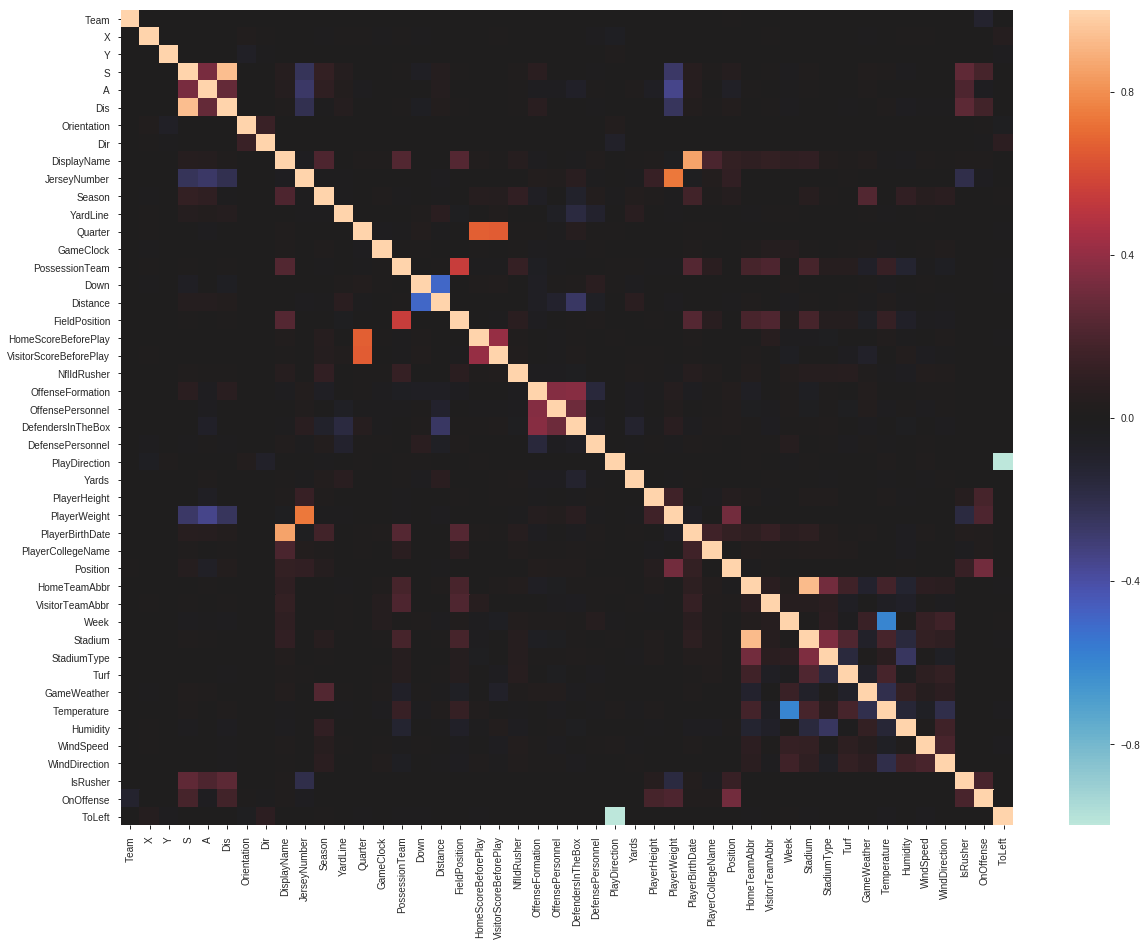

In [67]:
# heatmap
plt.figure(figsize=(20,15))
sns.heatmap(train_df[check_columns].corr(), vmax=1, vmin=-1, center=0)

## plot between yards(target) and other input variables

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0.5, 1.0, 'nan')

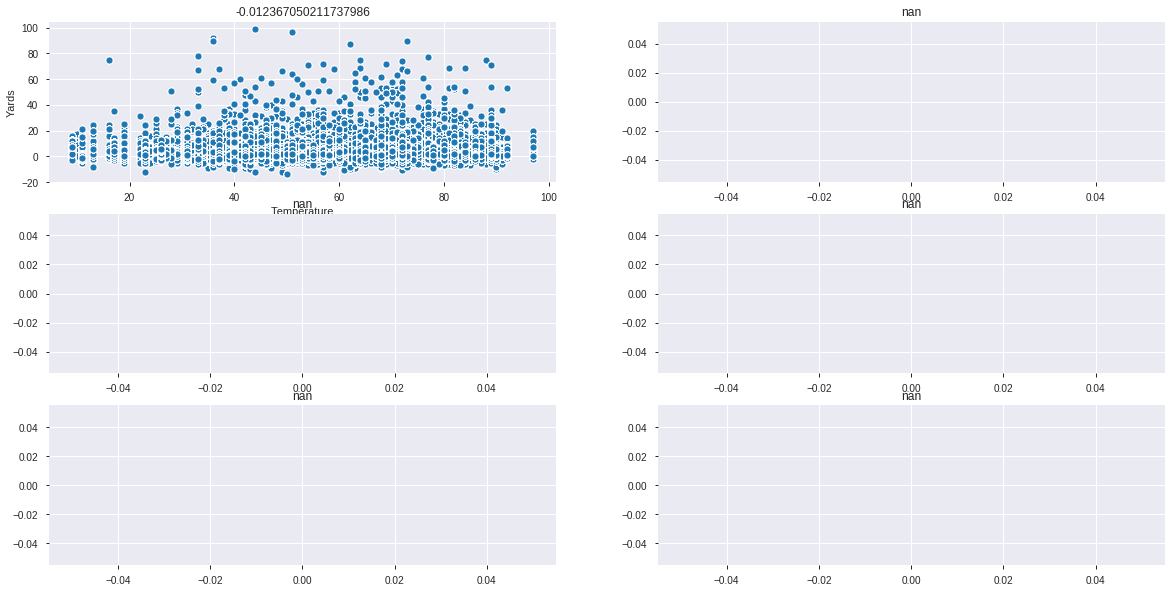

In [68]:
# yards vs stadiumtype and temperature
check_columns = ["Yards", "Temperature"]
outdoor_train = train_df[train_df.StadiumType == "outdoor"]
indooropen_train = train_df[train_df.StadiumType == "indoor open"]
indoorclose_train = train_df[train_df.StadiumType == "indoor closed"]
domeopen_train = train_df[train_df.StadiumType == "dome_closed"]
domeclose_train = train_df[train_df.StadiumType == "dome_open"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["Temperature"], train_df["Yards"])
plt.title(train_df[check_columns].corr().iloc[0,1])
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["Temperature"], outdoor_train["Yards"])
plt.title(outdoor_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["Temperature"], indooropen_train["Yards"])
plt.title(indooropen_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["Temperature"], indoorclose_train["Yards"])
plt.title(indoorclose_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["Temperature"], domeopen_train["Yards"])
plt.title(domeopen_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["Temperature"], domeclose_train["Yards"])
plt.title(domeclose_train[check_columns].corr().iloc[0,1])

Text(0.5, 1.0, 'domeclose')

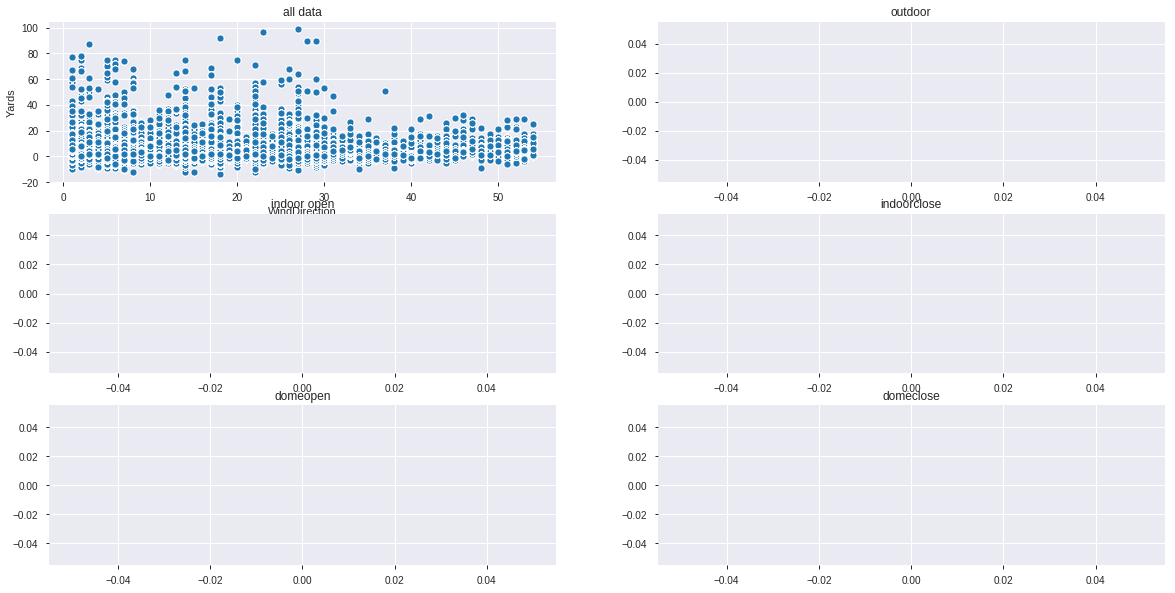

In [69]:
# yards vs stadiumtype and winddirection
check_columns = ["Yards", "WindDirection"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["WindDirection"], train_df["Yards"])
plt.title("all data")
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["WindDirection"], outdoor_train["Yards"])
plt.title("outdoor")
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["WindDirection"], indooropen_train["Yards"])
plt.title("indoor open")
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["WindDirection"], indoorclose_train["Yards"])
plt.title("indoorclose")
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["WindDirection"], domeopen_train["Yards"])
plt.title("domeopen")
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["WindDirection"], domeclose_train["Yards"])
plt.title("domeclose")

Text(0.5, 1.0, 'domeclose')

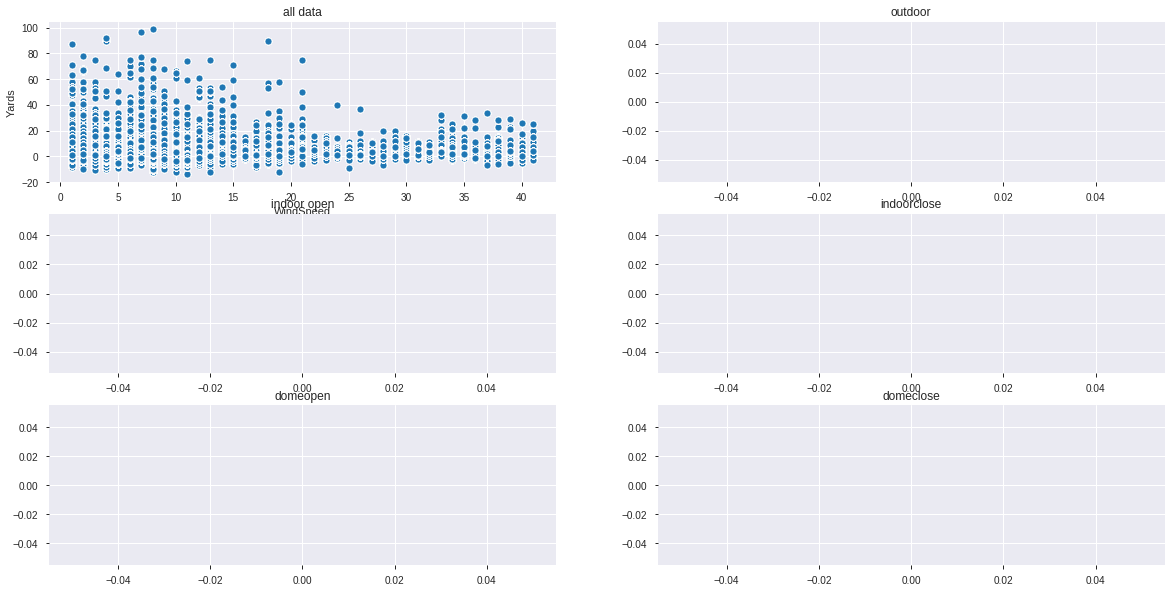

In [70]:
# yards vs stadiumtype and windspeed
check_columns = ["Yards", "WindSpeed"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["WindSpeed"], train_df["Yards"])
plt.title("all data")
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["WindSpeed"], outdoor_train["Yards"])
plt.title("outdoor")
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["WindSpeed"], indooropen_train["Yards"])
plt.title("indoor open")
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["WindSpeed"], indoorclose_train["Yards"])
plt.title("indoorclose")
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["WindSpeed"], domeopen_train["Yards"])
plt.title("domeopen")
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["WindSpeed"], domeclose_train["Yards"])
plt.title("domeclose")

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


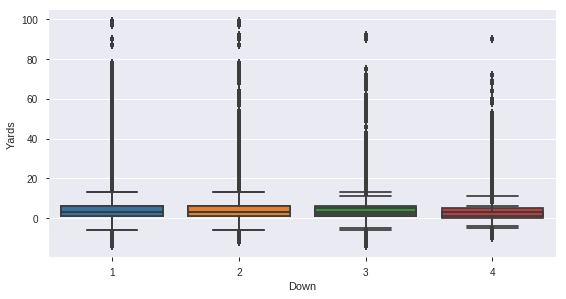

In [71]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.boxplot(train_df["Quarter"], train_df["Yards"])
plt.subplot(2,2,1)
sns.boxplot(train_df["Down"], train_df["Yards"])

In [72]:
pd.pivot_table(train_df, values="Yards", index="Down", columns="Quarter", aggfunc="mean")

Quarter,1,2,3,4,5
Down,,,,,
1,4.229977,4.519133,4.391578,4.052392,4.728972
2,4.064176,4.231695,4.355049,3.881786,5.040000
3,3.820375,4.087607,4.470032,4.078003,3.533333
4,3.000000,1.755102,3.303030,1.548387,1.000000


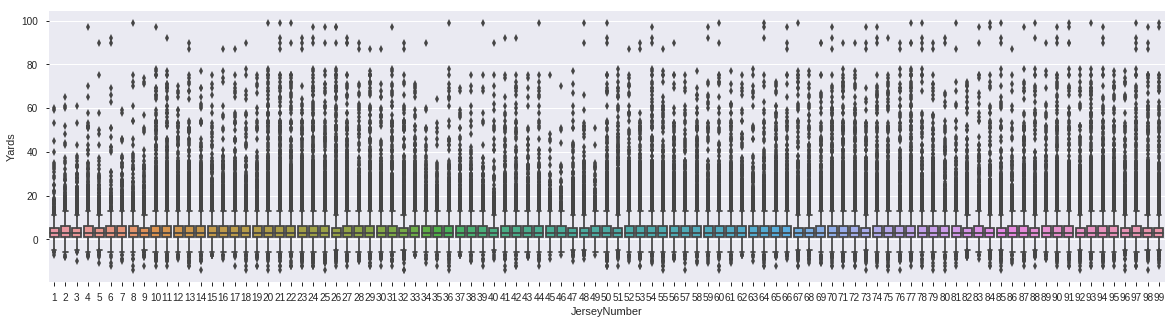

In [73]:
plt.figure(figsize=(20,5)) 
sns.boxplot(train_df["JerseyNumber"], train_df["Yards"])

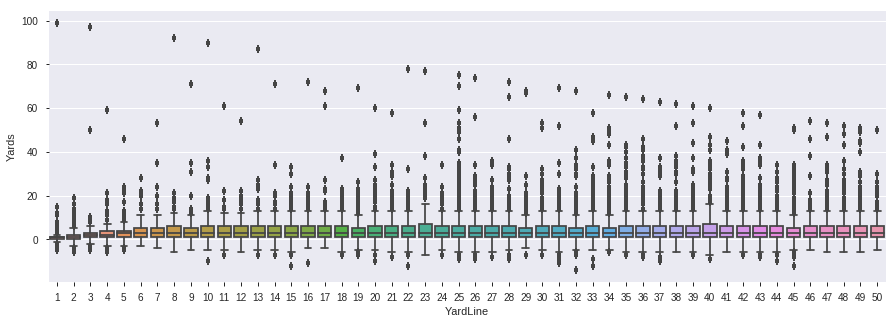

In [74]:
plt.figure(figsize=(15,5)) # clearly different
sns.boxplot(train_df["YardLine"], train_df["Yards"])

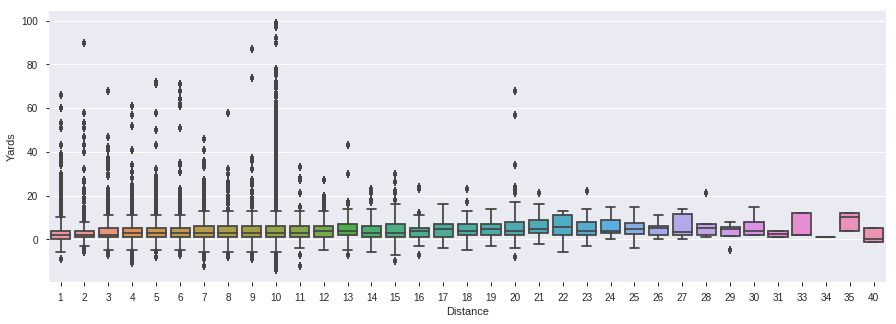

In [75]:
# Distance vs yards
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Distance"], train_df["Yards"])

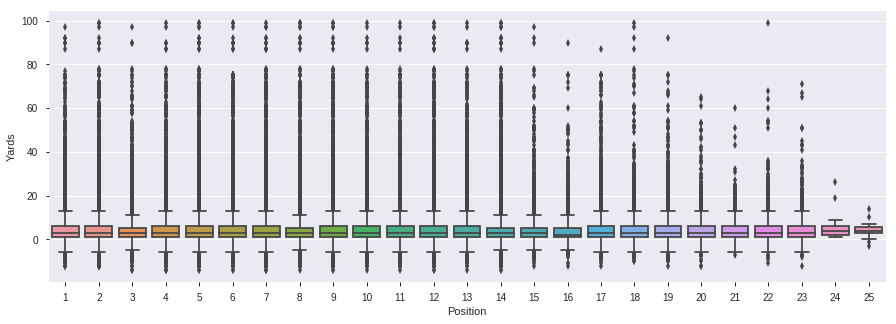

In [76]:
plt.figure(figsize=(15,5))
sns.boxplot(train_df["Position"], train_df["Yards"])

In [77]:
pd.pivot_table(train_df, values="Yards", index="Down", columns="Distance", aggfunc="mean")

Distance,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,40
Down,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.297753,0.562500,1.445946,1.578313,2.993750,2.743902,2.876543,3.295918,3.217391,4.468340,4.500000,5.000000,5.714286,6.750000,4.503876,1.625000,3.875000,3.666667,3.090909,5.110236,NaN,NaN,4.000000,5.0,3.333333,NaN,3.000000,NaN,NaN,4.666667,NaN,2.0,NaN,12.0,2.5
2,3.248991,3.604356,3.954939,3.807512,4.499276,4.129630,3.855049,4.019298,4.501075,4.721472,3.520710,4.212121,4.661972,3.431034,3.866667,4.642857,3.542857,4.931034,4.733333,6.571429,6.769231,6.454545,3.818182,4.0,5.545455,5.666667,5.666667,12.5,6.5,NaN,NaN,2.0,1.0,NaN,-1.0
3,3.373626,3.774809,5.000000,5.222222,5.322034,3.528302,4.191489,5.000000,4.972222,2.775510,4.448276,6.600000,4.807692,4.470588,7.733333,4.352941,6.200000,4.892857,6.307692,12.000000,5.111111,5.222222,9.000000,7.0,9.000000,3.750000,7.250000,4.0,-0.5,8.500000,2.5,12.0,NaN,7.0,NaN
4,2.029940,2.818182,5.250000,2.000000,6.000000,NaN,NaN,-3.000000,NaN,8.333333,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
pd.pivot_table(train_df, values="Yards", index="Dis", columns="Position", aggfunc="mean")

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Dis,,,,,,,,,,,,,,,,,,,,,,,,,
0.00,4.137931,3.674699,3.756757,4.140000,4.343195,4.221649,3.603774,4.821053,4.517241,4.441786,3.545455,3.772222,3.543353,4.105882,4.153846,2.0,6.363636,0.666667,3.190476,3.000000,NaN,3.000000,4.000000,NaN,NaN
0.01,4.613900,4.753363,5.045977,3.688022,4.647189,4.224622,3.909483,4.198953,4.297003,4.235838,4.138889,4.363636,4.462236,4.108597,3.175926,2.5,4.865854,4.812500,5.722222,5.687500,NaN,6.000000,4.166667,NaN,NaN
0.02,4.100592,4.324561,5.766667,3.765217,4.457627,3.952000,4.256881,4.324138,4.073171,4.702614,3.250000,3.540230,5.139738,4.948718,4.145833,0.5,5.093750,4.736842,4.031250,5.954545,-4.0,7.058824,7.600000,NaN,5.0
0.03,4.366492,3.980831,4.348315,3.944853,4.531128,3.893967,3.891089,3.885000,4.139651,4.461268,2.562500,3.918519,3.953069,4.053191,3.540146,NaN,6.431818,3.333333,4.666667,3.258065,NaN,2.000000,6.941176,NaN,NaN
0.04,4.475610,4.258953,4.130435,4.271293,4.880911,3.877850,3.226804,3.748387,3.897177,4.334395,5.166667,4.492784,4.362434,4.607930,4.475610,2.5,3.918367,4.363636,2.755102,2.300000,9.0,3.434783,2.812500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.10,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.13,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.16,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


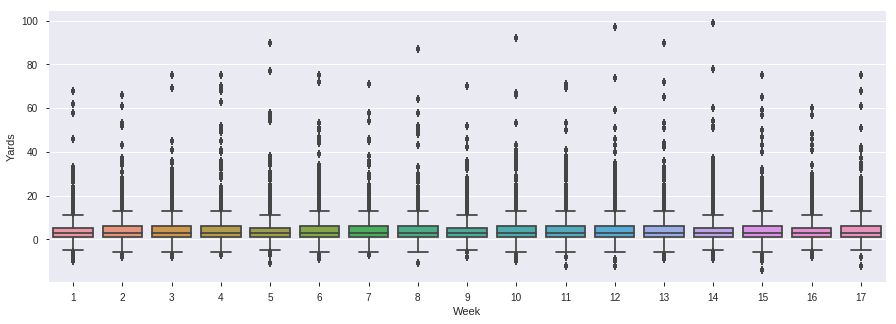

In [79]:
# week vs yards (seems to have no correlation)
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Week"], train_df["Yards"])

## plot between input variables

In [80]:
sns.distplot((train_df[train_df.OnOffense==True]["Orientation_std_mod"]).dropna())

KeyError: 'Orientation_std_mod'

In [81]:
sns.distplot((train_df[train_df.OnOffense==True]["Dir_std_mod"]).dropna())

KeyError: 'Dir_std_mod'

In [82]:
sns.distplot((train_df[train_df.OnOffense==False]["Orientation_std_mod"]).dropna())

KeyError: 'Orientation_std_mod'

In [83]:
sns.distplot((train_df[train_df.OnOffense==False]["Dir_std_mod"]).dropna())

KeyError: 'Dir_std_mod'

In [84]:
sns.distplot((train_df["Orientation_std_mod"]- train_df["Dir_std_mod"]).dropna())

KeyError: 'Orientation_std_mod'

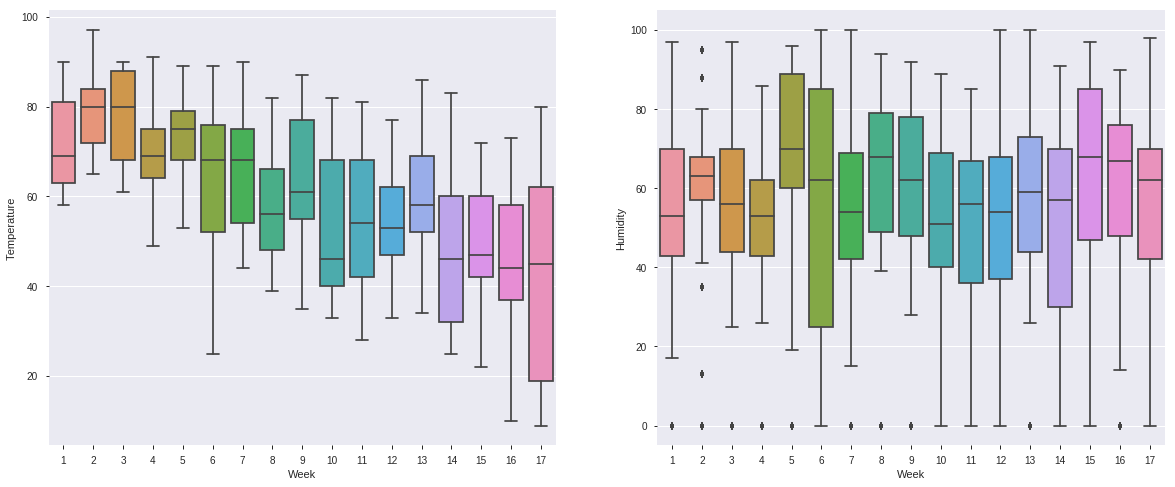

In [85]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(train_df["Week"], train_df["Temperature"])
plt.subplot(1,2,2)
sns.boxplot(train_df["Week"], train_df["Humidity"])

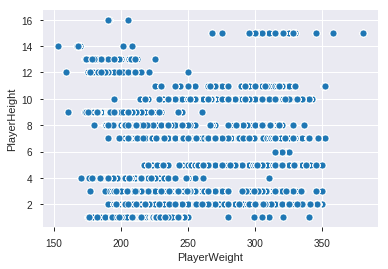

In [86]:
sns.scatterplot(train_df["PlayerWeight"], train_df["PlayerHeight"])

Home win   :  229416
Visitor win:  166034
Tie game   :  114312


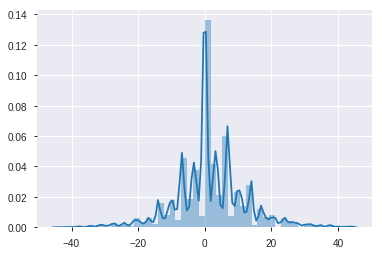

In [87]:
# score difference: almost the same, but more opportunities when home team lead the opponent
score_diff = train_df[train_df.columns[21]] - train_df[train_df.columns[22]]
print("Home win   : ", len(score_diff[score_diff > 0]))
print("Visitor win: ", len(score_diff[score_diff < 0]))
print("Tie game   : ", len(score_diff[score_diff == 0]))
sns.distplot(score_diff)

In [88]:
train_df[train_df.OnOffense == True]["Position"].value_counts() #QBは攻撃の要のはずだが、一プレイに一人いるわけではなさそう

7     49924
12    39478
9     39265
8     31074
13    22548
11    22297
10    21810
19     5700
5      3713
16     3010
20     2970
6      2330
2      2220
14     2208
4      1415
1      1287
3      1243
21      647
17      524
15      520
18      485
23      156
22       57
Name: Position, dtype: int64

# Player position by each play after my standardization of X, Y, Orientation, Dir and Yardline

In [89]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)
        
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line: # display scrimmage line
        hl = highlight_line_number
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [90]:
def voronoi_plot(points, rusher_index):
    v = Voronoi(points)
    for i, reg_num in enumerate(v.point_region):
        if reg_num == v.point_region[rusher_index]:
            index = i
            rusher_reg_num = reg_num
    # plot voronoi region -----------------------------
    #fig = plt.figure(figsize=(10,5))
    voronoi_plot_2d(v, show_vertices=False)
    #ax = fig.add_subplot(1,1,1)
    #ax.set_xlim(0,120)
    #ax.set_ylim(0,53.3)
    for region in v.regions: # color for only rusher
        if v.regions[rusher_reg_num] == region:
            polygon = [v.vertices[i] for i in region]
            plt.fill(*zip(*polygon), c="orange")
    # plot voronoi region -----------------------------  

def get_dx_dy(angle, dist):
    radian_angle = angle * math.pi/180.0
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

def show_play(play_id, train=train_df):
    plt.figure(figsize=(10,5))
    df = train_df[train_df.PlayId == play_id].copy().reset_index()
    YardLine = df.YardLine.values[0].copy()
    if df["X"].median() >= 60:
        YardLine = 60 + (50 - YardLine)
    else:
        YardLine = 10 + YardLine
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,)
    ax.scatter(df.X, df.Y, cmap='rainbow', c=~(df.Team == 'home'), s=100)
    
    # voronoi area check ---------------------------
    #pts = np.array(df[["X", "Y"]])
    #v = Voronoi(pts)
    #fig = voronoi_plot_2d(v)
    #rusher_index = df[df.IsRusher==True].index[0]
    #voronoi_plot(pts, rusher_index)
    # voronoi area check ---------------------------
    
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]
    
    # necessary to check only rusher's play ----------
    #x = rusher_row["X"].values[0] 
    #y = rusher_row["Y"].values[0]
    #rusher_dir = rusher_row["Dir_std"].values[0]
    #rusher_speed = rusher_row["S"].values[0]
    #dx, dy = get_dx_dy(rusher_dir, rusher_speed)
    #ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    # necessary to check only rusher play ----------

    # necessary to check all players ----------
    for (x, y, Dir, S) in zip(df.X, df.Y, df.Dir_std, df.S):
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    # necessary to check all players ----------
    
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()

In [91]:
def show_play_std(play_id, train=train_df):
    df = train_df[train_df.PlayId == play_id]
    YardLine = df.YardLine_std.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    ax.scatter(df.X_std, df.Y_std, cmap='rainbow', c=~df.OnOffense, s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X_std, df.Y_std, df.Dir_std_mod, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

In [92]:
# my standardization method
train_df["Dir_std"] = (360 - train_df.Dir.copy() + 90).mod(360)
train_df["Orientation_std"] = train_df["Orientation"].copy()
train_df.loc[train_df.Season == 2017, "Orientation_std"] = (360 - train_df['Orientation_std'][train_df['Season'] == 2017]).mod(360)
train_df.loc[train_df.Season == 2018, "Orientation_std"] = (360 - train_df['Orientation_std'][train_df['Season'] == 2018] + 90).mod(360)
# represent Yardline in terms of coordinate X
def func(row):
    if row["X"] >= 60:
        return 60 + (50 - row["YardLine"])
    else:
        return 10 + row["YardLine"]
tmp_df = train_df.groupby("PlayId").agg("median")[["X", "YardLine"]].reset_index(drop=True)
tmp_yardline = np.array(tmp_df.apply(func, axis=1))
train_df["YardLine_std"] = np.repeat(tmp_yardline, 22)

# To unite the offense direction to right, change X, Y, YardLine.
train_df['X_std'] = train_df.X.copy()
train_df.loc[train_df.ToLeft, 'X_std'] = 120 - train_df.loc[train_df.ToLeft, 'X']
#train_df.loc[train_df.ToLeft, 'X_std'] = 120 - train_df["X_std"][train_df['ToLeft'] == True] 
train_df['Y_std'] = train_df.Y.copy()
train_df.loc[train_df.ToLeft, 'Y_std'] = 160/3 - train_df.loc[train_df.ToLeft, 'Y']
train_df.loc[train_df.ToLeft, "YardLine_std"] = 120 - train_df["YardLine_std"][train_df['ToLeft'] == True]

# Additionally, rechange Orientation_std, Dir_std
train_df["Orientation_std_mod"] = train_df["Orientation_std"].copy()
train_df.loc[train_df.ToLeft, "Orientation_std_mod"] = train_df["Orientation_std_mod"][train_df['ToLeft'] == True].apply(lambda x: x-180 if x>180 and x<=360 else 180+x)
train_df["Dir_std_mod"] = train_df["Dir_std"].copy()
train_df.loc[train_df.ToLeft, "Dir_std_mod"] = train_df["Dir_std_mod"][train_df['ToLeft'] == True].apply(lambda x: x-180 if x>180 and x<=360 else 180+x)

In [93]:
np.transpose(train_df.iloc[0:22][["X", "X_std", "Y", "Y_std", "Dir_std", "Dir_std_mod", "ToLeft", "IsRusher", "YardLine", "YardLine_std"]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
X,73.91,74.67,74,71.46,69.32,75.06,74.11,73.37,56.63,73.35,74.15,75.82,74.78,75.43,75.9,79.76,76.47,74.7,78.75,74.6,74.58,74.58
X_std,46.09,45.33,46,48.54,50.68,44.94,45.89,46.63,63.37,46.65,45.85,44.18,45.22,44.57,44.1,40.24,43.53,45.3,41.25,45.4,45.42,45.42
Y,34.84,32.64,33.2,27.7,35.42,24,16.64,18.73,26.9,38.83,28.9,17.56,33.21,32.41,25.12,29.49,36.91,19.19,30.53,31.88,29.12,28.47
Y_std,18.4933,20.6933,20.1333,25.6333,17.9133,29.3333,36.6933,34.6033,26.4333,14.5033,24.4333,35.7733,20.1233,20.9233,28.2133,23.8433,16.4233,34.1433,22.8033,21.4533,24.2133,24.8633
Dir_std,272.82,251.3,247.27,344.36,285.69,354.99,127.41,179.96,34.69,259.16,175.86,165.85,234.1,227.24,251.45,339.14,254.91,171.48,204.26,182.68,207.95,194.33
Dir_std_mod,92.82,71.3,67.27,164.36,105.69,174.99,307.41,359.96,214.69,79.16,355.86,345.85,54.1,47.24,71.45,159.14,74.91,351.48,24.26,2.68,27.95,14.33
ToLeft,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
IsRusher,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
YardLine,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
YardLine_std,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45


<Figure size 720x360 with 0 Axes>

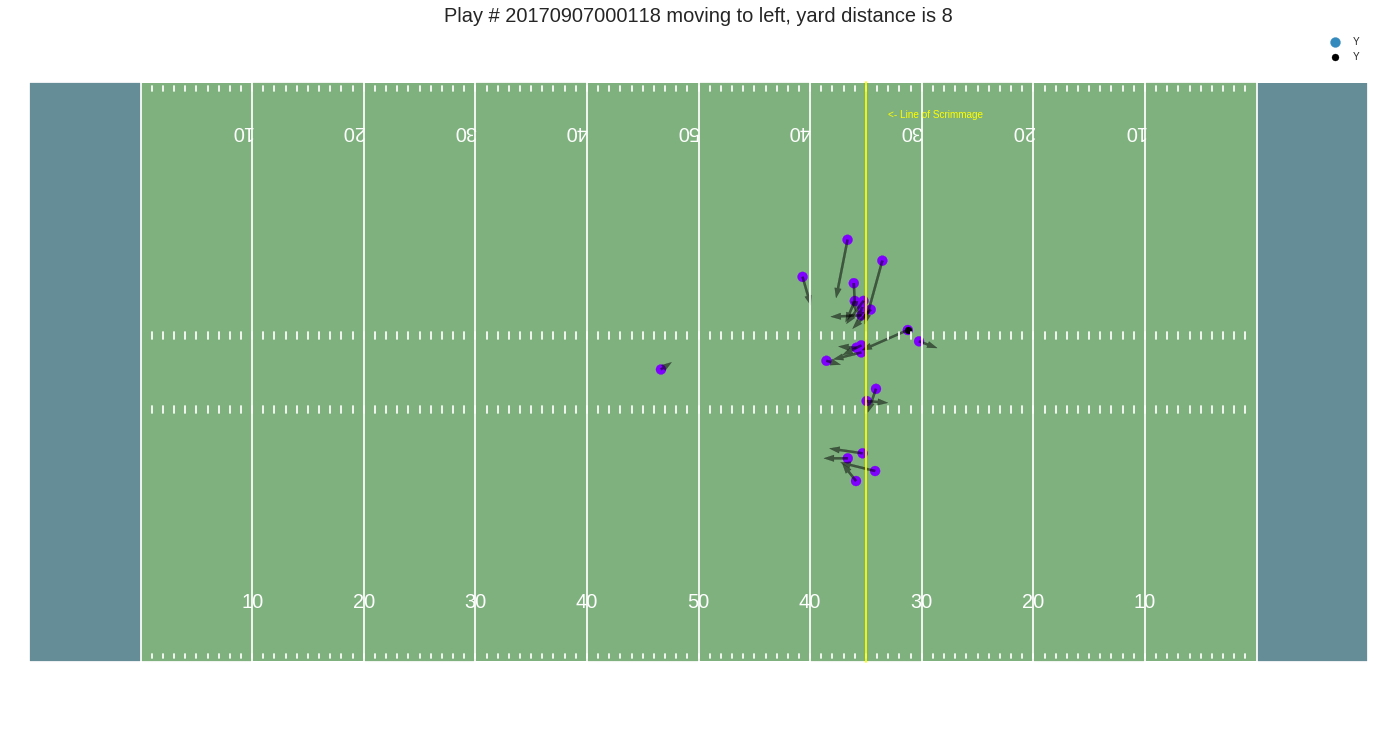

In [94]:
playid= list(train_df["PlayId"].unique())
show_play(playid[0])

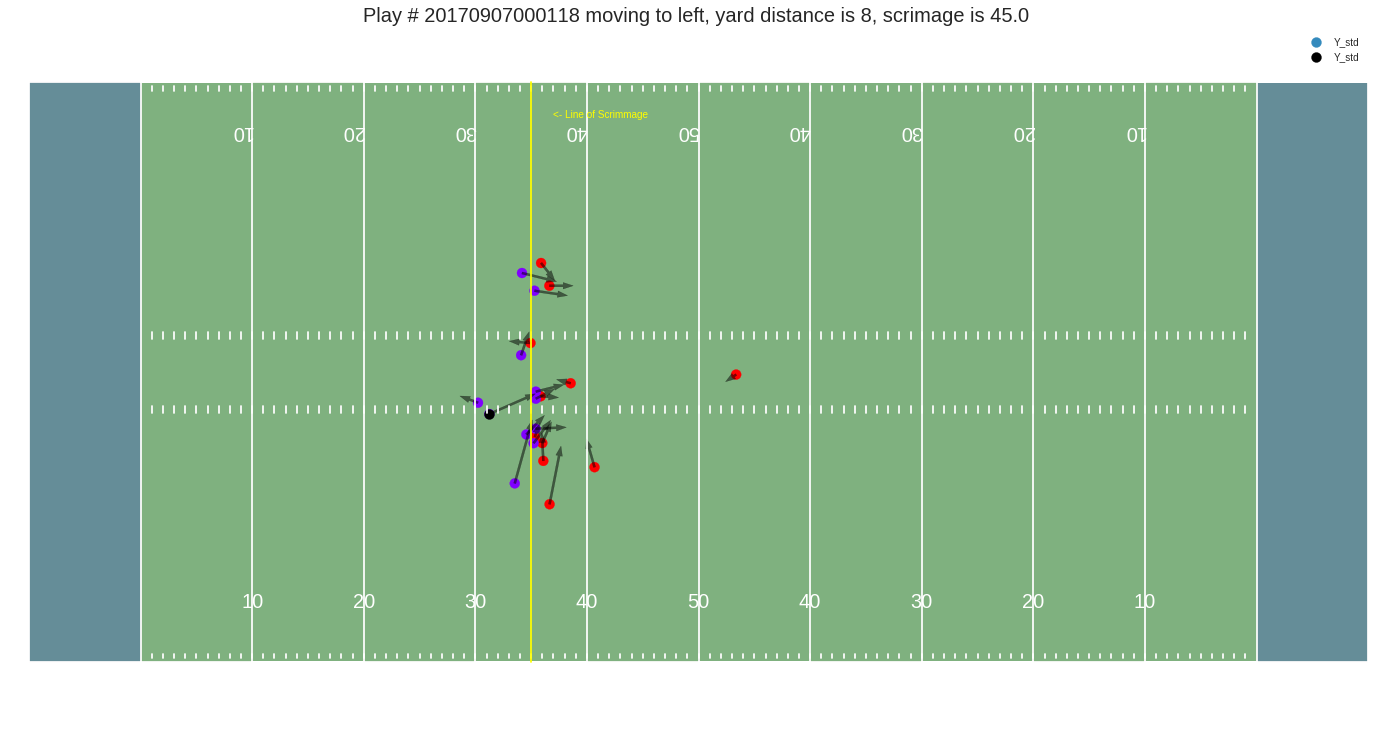

In [95]:
show_play_std(playid[0])

# voronoi area
Certainly, the area of voronoi regions affect the prediction quality, so I want to implement calculations of voronoi regions. However, when the area of voronoi region becomes infinity, additional processes are necessary.

In [96]:
def voronoi_volumes(points, rusher_index): # function to calculate voronoi area
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    
    #print("points:", points)
    #print(v.point_region) # index of voronoi region for each input point
    #print(v.regions) # voronoi points in each voronoi region
    for i, reg_num in enumerate(v.point_region):
        #print("i, reg_num:", (i, reg_num))
        indices = v.regions[reg_num]
        #print("regions:", indices)
        if -1 in indices: # some regions can be opened
            vol[i] = np.nan ## insert missing value when the area is open
            #print(v.vertices[indices])
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
        
        if reg_num == v.point_region[rusher_index]:
            #print("this is the voronoi area of rusher: ", vol[i])
            index = i
            rusher_reg_num = reg_num         
        
    return vol[index]

# calculate voronoi regions (sample) ----------------------------------
#pts = np.array(train_df.iloc[0:22][["X", "Y"]])
#tmp_df = train_df.iloc[0:22][["X", "Y", "IsRusher"]]
#rusher_index = tmp_df[tmp_df.IsRusher==True].index[0]
#voronoi_volumes(pts, rusher_index)
# --------------------------------------------------------------------

In [97]:
# calculation of voronoi area
def voronoi_volumes(points, rusher_index):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.nan ## insert missing value when the area is open
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
        
        if reg_num == v.point_region[rusher_index]: # in the case of rusher
            index = i
            rusher_reg_num = reg_num         
        
    return vol[index]

pts = np.array(train_df[["X", "Y"]]).reshape(train_df.shape[0]//22, 22, 2) # plays * players * (X, Y, rusher)
# index of row where rusher data is included when separated by each play
rusher_index = list(train_df[train_df.IsRusher==True].index % 22) 
rusher_voronoi = []
for i in tqdm.tqdm(range(0, train_df.shape[0] //22)):
    rusher_voronoi.append(voronoi_volumes(pts[i], rusher_index[i]))

100%|██████████| 23171/23171 [01:05<00:00, 352.99it/s]


# validation split

In [98]:
from sklearn.model_selection import KFold # some future data is included in the training data when we check the model performance in the validation data
kf=KFold(n_splits = 8)
X_train = train_df.copy()
X_train.sort_values(["GameId", "PlayId"], inplace=True)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print("fold:", i+1)
    #X_train2= X_train.iloc[train_index,:]
    #y_train2= y_train.iloc[train_index]
    training_data = X_train.iloc[train_index, :]
    # validation data
    X_test2= X_train.iloc[test_index,:].drop("Yards", axis=1)
    y_test2= X_train.iloc[test_index]["Yards"]
    
    test_first_gameid = min(X_test2["GameId"].unique())
    final_train_gameid = []
    for i in list(training_data["GameId"].unique()):
        if i < test_first_gameid:
            final_train_gameid.append(i)
    #print(final_train_gameid)
    if len(final_train_gameid) > len(X_test2["GameId"].unique()):
        final_training_data = training_data[training_data.GameId.isin(final_train_gameid)].reset_index(drop=True)
        X_train2 = final_training_data.drop("Yards", axis=1)
        y_train2 = final_training_data["Yards"]
        print(X_train2.shape[0])
        print(X_test2.shape[0])
    else:
        continue

fold: 1
fold: 2
fold: 3
126940
63720
fold: 4
190740
63720
fold: 5
254628
63720
fold: 6
317922
63720
fold: 7
381348
63720
fold: 8
445874
63720
